In [1]:
# MO444-A 2s/2017 - Third assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

# Plotting inline instead of opening an outer window.
%matplotlib inline

# Imports
import cgi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Markdown, display
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale

def printm(msg):
    """Print in notebook using markups."""
    display(Markdown(msg))

def loadIDs():
    lines=[]
    with open('documents/ids', "r") as f:
        lines = f.read().splitlines()
    return np.asarray(lines)

def loadFeatures():
    features = pd.read_csv('documents/data.csv', sep=',', header=None)
    return features.values

def loadDocument(docID):
    data = None
    with open('documents/docs/' + docID, 'r') as docfile:
        data = docfile.read()
    return data

In [2]:
ids = loadIDs()
print('IDs shape: {}'.format(ids.shape))

data = loadFeatures()
print('Data shape: {}'.format(data.shape))

IDs shape: (19924,)
Data shape: (19924, 2209)


In [3]:
# Let's look at the 5 first instances of the IDs
print(ids[0:5])

['832e15531654188fa0b951faa5f68540dfb1ca5a'
 'aa5163928a6edfd3bf69fd11fe763aacecf4602d'
 'e886703afff0c70d6598bcae0c2d69a5a237807f'
 'c1ea507b177b2e1673ce7a576057f91b75ae9d29'
 'bbf73405c85d22702fafc1c0916e8f713810ff8d']


In [4]:
# Now, let's have a look at the 5 first instances of the data (bag-of-words feature vectors)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208
0,0.077257,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055755,0.0,0.0
2,0.042250,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.093693,0.0,0.099296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.069105,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.036811,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.041917,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [5]:
# Checking the value ranges
print('Min. value: {}'.format(np.min(data.flatten())))
print('Max. value: {}'.format(np.max(data.flatten())))

# Let's scale and normalize the data
data = scale(data)

normalizer = Normalizer()
normalizer = normalizer.fit(data)

data = normalizer.transform(data)

Min. value: 0.0
Max. value: 0.999901


In [6]:
# Defining some auxiliary methods for running K Means
def printGraphsForMultipleCentroids(num_centroids, costs, sil_avgs, ch_scores):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col')

    ax1.set_title('cost')
    ax1.plot(num_centroids, costs)

    ax2.set_title('silhouettes')
    ax2.plot(num_centroids, sil_avgs)

    ax3.set_title('calinski harabaz score')
    ax3.plot(num_centroids, ch_scores)

    f.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    f.set_size_inches(15, 5)
    f.show()

def computeKMeansMetrics(model, data):
    labels = model.fit_predict(data)
    cost = model.inertia_
    sil_avg = silhouette_score(data, labels)
    ch_score = calinski_harabaz_score(data, labels)
    return labels, cost, sil_avg, ch_score

def runKmeansForMultipleCentroids(data):
    models, labels, costs, sil_avgs, ch_scores = [], [], [], [], []
    num_centroids = [2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
    for i in num_centroids:
        model = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=1)
        myLabels, cost, sil_avg, ch_score = computeKMeansMetrics(model, data)
        models.append(model)
        labels.append(myLabels)
        costs.append(cost)
        sil_avgs.append(sil_avg)
        ch_scores.append(ch_score)
        print('%d clusters: Cost %5.2f; Silhouette avg %5.5f; Calinski-Harabasz Index: %5.2f' % (i, cost, sil_avg, ch_score))
    printGraphsForMultipleCentroids(num_centroids, costs, sil_avgs, ch_scores)
    return models, labels, costs, sil_avgs, ch_scores

2 clusters: Cost 19800.31; Silhouette avg 0.00620; Calinski-Harabasz Index: 123.59
4 clusters: Cost 19700.97; Silhouette avg 0.00489; Calinski-Harabasz Index: 75.24
6 clusters: Cost 19626.00; Silhouette avg 0.00487; Calinski-Harabasz Index: 61.02
8 clusters: Cost 19512.65; Silhouette avg 0.00627; Calinski-Harabasz Index: 60.47
10 clusters: Cost 19470.62; Silhouette avg 0.00697; Calinski-Harabasz Index: 52.24
15 clusters: Cost 19298.33; Silhouette avg 0.00880; Calinski-Harabasz Index: 47.28
20 clusters: Cost 19160.94; Silhouette avg 0.01065; Calinski-Harabasz Index: 42.66
25 clusters: Cost 19009.95; Silhouette avg 0.01246; Calinski-Harabasz Index: 40.45
30 clusters: Cost 18904.53; Silhouette avg 0.01470; Calinski-Harabasz Index: 37.75
35 clusters: Cost 18842.39; Silhouette avg 0.01425; Calinski-Harabasz Index: 34.22
40 clusters: Cost 18685.07; Silhouette avg 0.01643; Calinski-Harabasz Index: 34.38
45 clusters: Cost 18640.97; Silhouette avg 0.01788; Calinski-Harabasz Index: 31.79
50 clus

/Library/Python/2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


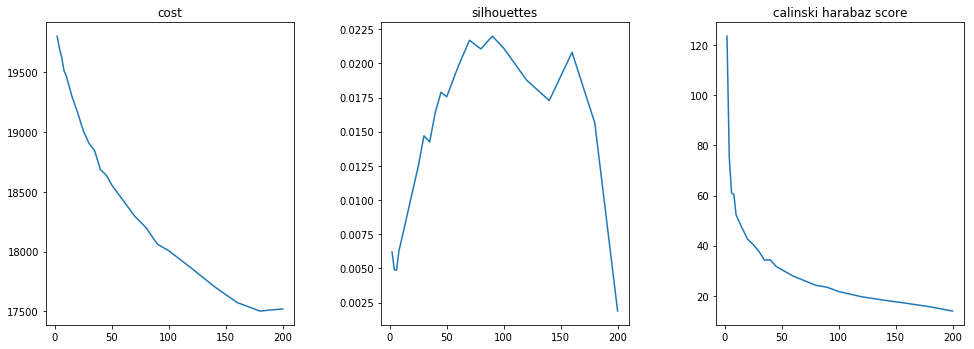

In [7]:
# Attempting Mini-Batch K means with some different number of centroids.
models, labels, costs, sil_avgs, ch_scores = runKmeansForMultipleCentroids(data)

In [8]:
##### Let's check some sample groups, their medoid documents, and two other closer documents.
def loadEscapedDoc(doc_id):
    return cgi.escape(loadDocument(doc_id).replace('$', '').replace('*', '')).replace('\n', '<br>')

def analyze_centroids(chosen_model, chosen_model_labels, data):
    tbl = ['<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr>']
    td_style = 'style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;"'
    groups = np.random.choice(chosen_model.n_clusters, 5, replace=False)
    print('Selected groups: {}'.format(groups))
    for i in groups:
        center = chosen_model.cluster_centers_[i]
        group_points = data[chosen_model_labels == i]
        group_doc_ids = ids[chosen_model_labels == i]

        # Let's find the medoid and their closest points
        distancesMatrix = pairwise_distances(group_points, metric='euclidean')
        closest_to_medoid_indexes = np.argsort(distancesMatrix.sum(axis=0))
        medoid_index = closest_to_medoid_indexes[0]

        medoid = group_doc_ids[medoid_index]
        closest1 = group_doc_ids[closest_to_medoid_indexes[1]]
        closest2 = group_doc_ids[closest_to_medoid_indexes[2]]
        tbl.append('<td %s>**%s**<br>%s</td>'
                   '<td %s>**%s**<br>%s</td>'
                   '<td %s>**%s**<br>%s</td>' % (
            td_style, medoid, loadEscapedDoc(medoid),
            td_style, closest1, loadEscapedDoc(closest1),
            td_style, closest2, loadEscapedDoc(closest2)))

    tbl.append('</tr></table>')
    printm('</tr><tr>'.join(tbl))

In [9]:
# Chosen number of centroids
chosen_i = 16 # Meaning 90 centroids
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
analyze_centroids(chosen_model, chosen_model_labels, data)

Chosen # of centroids: 90
Cost:                             18062.589
Silhouette avg:                       0.022
Calinski-Harabasz Index:             23.417
Selected groups: [34 13 63 86 69]


<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**4a2d60ef2932a196bd807a0ebcc44ad0c9da79f2**<br>Xref: cantaloupe.srv.cs.cmu.edu soc.culture.arabic:19850 soc.culture.bosna-herzgvna:3905 soc.culture.indian:128877 soc.culture.iranian:23566 soc.culture.jewish:65294 soc.culture.pakistan:40032 soc.culture.turkish:35334 talk.politics.mideast:77244 soc.culture.african:15032 soc.culture.malaysia:2453<br>Newsgroups: soc.culture.arabic,soc.culture.bosna-herzgvna,soc.culture.indian,soc.culture.iranian,soc.culture.jewish,soc.culture.pakistan,soc.culture.turkish,soc.culture.afganistan,talk.politics.mideast,soc.culture.african,soc.culture.malaysia<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!usc!cs.utexas.edu!utnut!skule.ecf!drill.me!arnsenad<br>From: arnsenad@me.utoronto.ca (Senad Arnautovic)<br>Subject: Re: Europe vs. Muslim Bosnians<br>Message-ID: &lt;C6xDIB.Dpn@me.utoronto.ca&gt;<br>Sender: news@me.utoronto.ca (News Reader)<br>Organisation: U of Toronto, Dept. of Mechanical Engineering<br>Organization: UofT Mechanical Engineering<br>References: &lt;1sof9tp6u@transfer.stratus.com&gt; &lt;C6x44y.3xD@cbfsb.cb.att.com&gt; &lt;C6x81M.EJF@news.cis.umn.edu&gt;<br>Date: Wed, 12 May 1993 17:49:22 GMT<br>Lines: 21<br><br>prabhak@giga.cs.umn.edu (Satya Prabhakar) writes:<br><br>&gt;(mohamed.s.sadek) writes:<br>&gt;&gt;<br>&gt;&gt;I like what Mr. Joseph Biden had to say yesterday 5/11/93 in the senate.<br>&gt;&gt;<br>&gt;&gt;Condemening the european lack of action and lack of support to us plans <br>&gt;&gt;and calling that "moral rape".<br>&gt;&gt;<br>&gt;&gt;He went on to say that the reason for that is "out right religious BIGOTRY"<br><br>&gt;Actually, this strife in Yugoslavia goes back a long way. Bosinan Muslims,<br>&gt;in collaboration with the Nazis, did to Serbians after the first world<br>&gt;war what Serbs are doing to Muslims now.<br><br>Where in the world did you get this? Please read history books before<br>you start talking something<br><br>&gt;Satya Prabhakar<br><br>Senad Arnautovic<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**340a13ddc1e26264c7c04ede0f47edb6ba88f0d2**<br>Xref: cantaloupe.srv.cs.cmu.edu soc.culture.arabic:19833 soc.culture.bosna-herzgvna:3900 soc.culture.indian:128856 soc.culture.iranian:23555 soc.culture.jewish:65280 soc.culture.pakistan:40020 soc.culture.turkish:35324 soc.culture.yugoslavia:17892 talk.politics.mideast:77241 soc.culture.african:15027 soc.culture.malaysia:2448<br>Newsgroups: soc.culture.arabic,soc.culture.bosna-herzgvna,soc.culture.indian,soc.culture.iranian,soc.culture.jewish,soc.culture.pakistan,soc.culture.turkish,soc.culture.yugoslavia,soc.culture.afganistan,talk.politics.mideast,soc.culture.african,soc.culture.malaysia<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!darwin.sura.net!news-feed-1.peachnet.edu!umn.edu!giga!prabhak<br>From: prabhak@giga.cs.umn.edu (Satya Prabhakar)<br>Subject: Re: Europe vs. Muslim Bosnians<br>Message-ID: &lt;C6x81M.EJF@news.cis.umn.edu&gt;<br>Sender: news@news.cis.umn.edu (Usenet News Administration)<br>Nntp-Posting-Host: giga.cs.umn.edu<br>Organization: University of Minnesota, Minneapolis, CSci dept.<br>References: &lt;1sof9tp6u@transfer.stratus.com&gt; &lt;C6x44y.3xD@cbfsb.cb.att.com&gt;<br>Date: Wed, 12 May 1993 15:50:31 GMT<br>Lines: 20<br><br>(mohamed.s.sadek) writes:<br>&gt;<br>&gt;I like what Mr. Joseph Biden had to say yesterday 5/11/93 in the senate.<br>&gt;<br>&gt;Condemening the european lack of action and lack of support to us plans <br>&gt;and calling that "moral rape".<br>&gt;<br>&gt;He went on to say that the reason for that is "out right religious BIGOTRY"<br><br>Actually, this strife in Yugoslavia goes back a long way. Bosinan Muslims,<br>in collaboration with the Nazis, did to Serbians after the first world<br>war what Serbs are doing to Muslims now. This is not a fresh case of<br>ethnic cleansing but just another chapter in the continuing saga<br>of intense mutual hatred, destruction,... Not taking sides in this<br>perpetual war does not amount to religious bigotry. It could just<br>be helplessness with regards to bringing peace to a region that does<br>not even know the meaning of the word.<br><br>Satya Prabhakar<br>--<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**12c06bd133a2491147e8e65ef5834ed730c39b17**<br>Xref: cantaloupe.srv.cs.cmu.edu soc.culture.arabic:19836 soc.culture.bosna-herzgvna:3901 soc.culture.indian:128862 soc.culture.iranian:23556 soc.culture.jewish:65284 soc.culture.pakistan:40023 soc.culture.turkish:35327 soc.culture.yugoslavia:17893 talk.politics.mideast:77242 soc.culture.african:15029 soc.culture.malaysia:2449<br>Newsgroups: soc.culture.arabic,soc.culture.bosna-herzgvna,soc.culture.indian,soc.culture.iranian,soc.culture.jewish,soc.culture.pakistan,soc.culture.turkish,soc.culture.yugoslavia,soc.culture.afganistan,talk.politics.mideast,soc.culture.african,soc.culture.malaysia<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!ux1.cso.uiuc.edu!newsrelay.iastate.edu!news.iastate.edu!IASTATE.EDU!jakhan<br>From: jakhan@IASTATE.EDU (Javed Ahmed Khan)<br>Subject: Re: Europe vs. Muslim Bosnians<br>Message-ID: &lt;1993May12.111030@IASTATE.EDU&gt;<br>Sender: news@news.iastate.edu (USENET News System)<br>Reply-To: jakhan@IASTATE.EDU (Javed Ahmed Khan)<br>Organization: Iowa State University<br>References: &lt;1sof9tp6u@transfer.stratus.com&gt; &lt;C6x44y.3xD@cbfsb.cb.att.com&gt; &lt;C6x81M.EJF@news.cis.umn.edu&gt;<br>Date: Wed, 12 May 1993 16:10:30 GMT<br>Lines: 36<br><br>In article &lt;C6x81M.EJF@news.cis.umn.edu&gt;, prabhak@giga.cs.umn.edu (Satya<br>Prabhakar) writes:<br>&gt; (mohamed.s.sadek) writes:<br>&gt; &gt;<br>&gt; &gt;I like what Mr. Joseph Biden had to say yesterday 5/11/93 in the senate.<br>&gt; &gt;<br>&gt; &gt;Condemening the european lack of action and lack of support to us plans <br>&gt; &gt;and calling that "moral rape".<br>&gt; &gt;<br>&gt; &gt;He went on to say that the reason for that is "out right religious BIGOTRY"<br>&gt; <br>&gt; Actually, this strife in Yugoslavia goes back a long way. Bosinan Muslims,<br>                                                            ^^^^^^^^^^^^^^^<br>&gt; in collaboration with the Nazis, did to Serbians after the first world<br>  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^<br>&gt; war what Serbs are doing to Muslims now. This is not a fresh case of<br>&gt; ethnic cleansing but just another chapter in the continuing saga<br>&gt; of intense mutual hatred, destruction,... Not taking sides in this<br>&gt; perpetual war does not amount to religious bigotry. It could just<br>&gt; be helplessness with regards to bringing peace to a region that does<br>&gt; not even know the meaning of the word.<br>&gt; <br><br><br>I dont think you're correct here. There have been no reports of the Bosnians<br>Muslims supporting the Nazis in their genocide against the Serbians. The fact is<br>that the Croat govt. using their secret police (called the Ustache, I think)<br>were the prime agents of the Nazis in Yugoslavia against the Serbs.<br> <br><br><br>&gt; Satya Prabhakar<br>&gt; --<br><br><br>--Javed.<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**a0ddf5a01d059c309fe49941eae34dcadc5b16fa**<br>Newsgroups: comp.sys.mac.hardware<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!swrinde!gatech!purdue!mentor.cc.purdue.edu!sage.cc.purdue.edu!jcs<br>From: jcs@sage.cc.purdue.edu (Stalnaker)<br>Subject: System 6.0.8L<br>Message-ID: &lt;C5tCnv.3AF@mentor.cc.purdue.edu&gt;<br>Sender: news@mentor.cc.purdue.edu (USENET News)<br>Organization: Purdue University Computing Center<br>Date: Wed, 21 Apr 1993 03:06:57 GMT<br>Lines: 5<br><br>-- <br>      ____<br>  Y_,_|[]|   Ernest Stalnaker<br> {|_|_|__|   jcs@sage.cc.purdue.edu<br> //oo--OO    ...!pur-ee!sage.cc!jcs<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**b301c86c167a04e6c9aadbe0d99cbbf4cf5cb986**<br>Newsgroups: rec.sport.hockey<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!sample.eng.ohio-state.edu!purdue!mentor.cc.purdue.edu!noose.ecn.purdue.edu!rainbow.ecn.purdue.edu!stamber<br>From: stamber@rainbow.ecn.purdue.edu (Kevin L. Stamber)<br>Subject: LIST OF TEE TIMES AT METROPOLITAN TORONTO GOLF COURSES FOR MONDAY<br>Message-ID: &lt;C5spEC.EuC@noose.ecn.purdue.edu&gt;<br>Sender: news@noose.ecn.purdue.edu (USENET news)<br>Organization: Purdue University Engineering Computer Network<br>Date: Tue, 20 Apr 1993 18:44:35 GMT<br>Lines: 6<br><br>;^)<br><br>Kevin L. Stamber<br>Purdue University<br>...and Phil Kirzyc (The Kielbasa Kid) will roam the Arena for interviews.<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**5c76aab5fee7c9f83a6b480b727c57163dd724ac**<br>Newsgroups: rec.autos<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!gatech!purdue!mentor.cc.purdue.edu!feserve.cc.purdue.edu!marshatt<br>From: marshatt@feserve.cc.purdue.edu (Zauberer)<br>Subject: Re: WARNING.....(please read)...<br>Message-ID: &lt;C5t0CF.J7F@mentor.cc.purdue.edu&gt;<br>Sender: news@mentor.cc.purdue.edu (USENET News)<br>Organization: Purdue University<br>References: &lt;C5K9M5.7Ku@constellation.ecn. &lt;1993Apr19.145238.9561@magnus.acs.ohio-state.edu&gt; &lt;C5srIB.6AH@constellation.ecn.uoknor.edu&gt;<br> <br> Can we please stick to AUTOMOTIVE topics . Thank you.<br>Date: Tue, 20 Apr 1993 22:41:02 GMT<br>Lines: 1<br><br><br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c30c5e03fe3ef35f4266def5b8d4063ad8b11231**<br>Xref: cantaloupe.srv.cs.cmu.edu soc.culture.arabic:18711 talk.politics.mideast:76222 soc.culture.jewish:63589<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!wupost!usc!news.service.uci.edu!orion.oac.uci.edu!tclock<br>From: tclock@orion.oac.uci.edu (Tim Clock)<br>Subject: Re: Israeli Terrorism<br>Nntp-Posting-Host: orion.oac.uci.edu<br>Message-ID: &lt;2BDAD779.24910@news.service.uci.edu&gt;<br>Newsgroups: soc.culture.arabic,talk.politics.mideast,soc.culture.jewish<br>Organization: University of California, Irvine<br>Lines: 19<br>Date: 25 Apr 93 18:24:57 GMT<br>References: &lt;2BD9C01D.11546@news.service.uci.edu&gt; &lt;1rd7eo1a4@usenet.INS.CWRU.Edu&gt; &lt;AMOSS.93Apr25163327@shuldig.cs.huji.ac.il&gt;<br><br>In article &lt;AMOSS.93Apr25163327@shuldig.cs.huji.ac.il&gt; amoss@shuldig.cs.huji.ac.il (Amos Shapira) writes:<br>&gt;cy779@cleveland.Freenet.Edu (Anas Omran) writes:<br>&gt;<br>&gt;                                                           The Israelis<br>&gt;   used to arrest and sometimes to kill some of these neutral reporters.<br>&gt;<br>&gt;Eh????  Could you please give me details about an event where a "Neutral<br>&gt;Observer" was killed by purpose by an Israeli soldier?<br>&gt;<br>&gt;--Amos<br>&gt;<br>Actually, I'm still trying to understand the self-justifying rationale<br>behind the recent murder of Ian Feinberg (?) in Gaza.<br><br>--<br>Tim Clock                                   Ph.D./Graduate student<br>UCI  tel#: 714,8565361                      Department of Politics and Society<br>     fax#: 714,8568441                      University of California - Irvine<br>Home tel#: 714,8563446                      Irvine, CA 92717<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**b9580de028a29333b771f6e5b6ebf5dfa4f63210**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.politics.mideast:77819<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!usc!news.service.uci.edu!orion.oac.uci.edu!tclock<br>From: tclock@orion.oac.uci.edu (Tim Clock)<br>Subject: Re: Genuine Admission From A Genuine Homosexual<br>Nntp-Posting-Host: orion.oac.uci.edu<br>Message-ID: &lt;2C01C6C2.21660@news.service.uci.edu&gt;<br>Newsgroups: talk.politics.mideast<br>Organization: University of California, Irvine<br>Lines: 15<br>Date: 25 May 93 07:12:02 GMT<br>References: &lt;10thpbd5sn@usenet.INS.CWRU.Edu&gt;<br><br>In article &lt;10thpbd5sn@usenet.INS.CWRU.Edu&gt; aa824@cleveland.Freenet.Edu (Mark Ira Kaufman) writes:<br>&gt;<br>&gt;   I  must  finally  admit the total truth that is central to the<br>&gt;core of my being.<br>&gt;<br>&gt;your erection insinuating itself into my kosher rectum always will.<br>&gt;<br>&gt;                                =Mark=<br><br>What say you and Nick go somewhere else with this shool yard crap.<br>--<br>Tim Clock                                   Ph.D./Graduate student<br>UCI  tel#: 714,8565361                      Department of Politics and Society<br>     fax#: 714,8568441                      University of California - Irvine<br>Home tel#: 714,8563446                      Irvine, CA 92717<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**92dcff875d92b3c0e97229e1eeb74e4bc04577b9**<br>Xref: cantaloupe.srv.cs.cmu.edu soc.culture.arabic:19118 talk.politics.mideast:76540 soc.culture.jewish:64131<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!news.service.uci.edu!orion.oac.uci.edu!tclock<br>From: tclock@orion.oac.uci.edu (Tim Clock)<br>Subject: Re: Israeli Media (was Re: Israeli Terrorism)<br>Nntp-Posting-Host: orion.oac.uci.edu<br>Message-ID: &lt;2BDF6E30.26971@news.service.uci.edu&gt;<br>Newsgroups: soc.culture.arabic,talk.politics.mideast,soc.culture.jewish<br>Organization: University of California, Irvine<br>Lines: 19<br>Date: 29 Apr 93 05:57:04 GMT<br>References: &lt;2BD9C01D.11546@news.service.uci.edu&gt; &lt;1993Apr26.114220.20245@ncsu.edu&gt; &lt;C67nJt.H0u@bony1.bony.com&gt;<br><br>In article &lt;C67nJt.H0u@bony1.bony.com&gt; jake@bony1.bony.com (Jake Livni) writes:<br>&gt;In article &lt;1993Apr26.114220.20245@ncsu.edu&gt; hernlem@chess.ncsu.edu (Brad Hernlem) writes:<br>&gt;<br>&gt;&gt;Jake can call me Doctor Mohandes Brad "Ali" Hernlem (as of last Wednesday)<br>&gt;<br>&gt;Congratulations.  In what field is this doctorate?<br>&gt;<br>&gt;-- <br>&gt;Jake Livni  jake@bony1.bony.com           Ten years from now, George Bush will<br>&gt;American-Occupied New York                   have replaced Jimmy Carter as the<br>&gt;My opinions only - employer has no opinions.    standard of a failed President.<br><br>I add my congratulations as well. To all those who survive the gauntlet,<br>cheers.<br>--<br>Tim Clock                                   Ph.D./Graduate student<br>UCI  tel#: 714,8565361                      Department of Politics and Society<br>     fax#: 714,8568441                      University of California - Irvine<br>Home tel#: 714,8563446                      Irvine, CA 92717<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**df7555a237b3a307643b50370e37cd873d8be35e**<br>Newsgroups: talk.politics.guns<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!geraldo.cc.utexas.edu!portal.austin.ibm.com!awdprime.austin.ibm.com!mlh<br>From: mlh@austin.ibm.com (Sewer Snake)<br>Subject: Re: BATF Acronym<br>Originator: mlh@eddy.austin.ibm.com<br>Message-ID: &lt;C5wEMH.2G2s@austin.ibm.com&gt;<br>Sender: mlh@austin.ibm.com ()<br>Date: Thu, 22 Apr 1993 18:42:17 GMT<br>Reply-To: mlh@austin.ibm.com<br>References: &lt;1993Apr21.050536.508@ucsu.Colorado.EDU&gt; &lt;8110360@hpfcso.FC.HP.COM&gt;<br>Organization: IBM Austin<br>Lines: 6<br><br><br><br>	B urn<br>	A ll<br>	T he<br>	F uckers<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**9e1fa4afa23c32473aa92f7bdbefbe41620a961d**<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!uwm.edu!cs.utexas.edu!geraldo.cc.utexas.edu!portal.austin.ibm.com!awdprime.austin.ibm.com!leapman<br>From: leapman@austin.ibm.com<br>Newsgroups: sci.electronics<br>Subject: HeathKit/Zenith<br>Message-ID: &lt;C52EGz.27t3@austin.ibm.com&gt;<br>Date: 6 Apr 93 13:50:59 GMT<br>Article-I.D.: austin.C52EGz.27t3<br>Sender: news@austin.ibm.com (News id)<br>Reply-To: LOGIN@austin.ibm.com<br>Organization: IBM Austin<br>Lines: 3<br>Originator: leapman@junior.austin.ibm.com<br><br><br>Does anyone out there have the toll-free (catalog request and order line) for<br>Heathkit/Zenith?  Please post the number if you've got it!  Thanks.<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**366ae5fa9ba3d77de51dde2471cdc3b8355c8e76**<br>Newsgroups: sci.med<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!geraldo.cc.utexas.edu!portal.austin.ibm.com!awdprime.austin.ibm.com!jmetz<br>From: jmetz@austin.ibm.com ()<br>Subject: Re: Twitching eye?<br>Originator: jmetz@jmetz.austin.ibm.com<br>Sender: news@austin.ibm.com (News id)<br>Message-ID: &lt;C52JK5.2611@austin.ibm.com&gt;<br>Date: Tue, 6 Apr 1993 15:40:53 GMT<br>References:  &lt;93092.43688.J056600@LMSC5.IS.LMSC.LOCKHEED.COM&gt;<br>Organization: IBM Austin<br>Lines: 4<br><br><br>  I had this one time.  I attributed it to a lack of sleep since it disappeared<br>after a few nights of good zzz's.<br><br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**e4933120778b19c070c42743940fce7c135b542e**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.sys.mac.hardware:51502 comp.sys.mac.misc:43144 comp.sys.mac.apps:34927 comp.sys.mac.system:30170<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!spool.mu.edu!uwm.edu!ogicse!news.u.washington.edu!serval!moscow.uidaho.edu!groucho.mrc.uidaho.edu!mbeale<br>From: mbeale@groucho.mrc.uidaho.edu (Mark Beale)<br>Newsgroups: comp.sys.mac.hardware,comp.sys.mac.misc,comp.sys.mac.apps,comp.sys.mac.system<br>Subject: Re: Quadra Acceleration<br>Message-ID: &lt;C5G4MM.6xI@moscow.uidaho.edu&gt;<br>Date: 13 Apr 93 23:44:45 GMT<br>Article-I.D.: moscow.C5G4MM.6xI<br>References: &lt;1993Apr9.035951.23701@pcnntp.apple.com&gt;<br>Sender: news@moscow.uidaho.edu<br>Distribution: na<br>Organization: Microelectronics Research Center<br>Lines: 7<br>Nntp-Posting-Host: groucho.mrc.uidaho.edu<br><br>About this QUADRA 700, 800 clock acceleration: has anyone heard<br>of anything like it for the QUADRA 950?<br><br>Please reply e-mail, I don't get to the news very often.  Thanks!!<br><br>Mark Beale<br>mbeale(at)wallaby.mrc.uidaho.edu<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**9e94b0c241c8fd79d9e0d06a3e147aabd12d6877**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.sys.mac.hardware:51668 comp.sys.mac.system:30261<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!swrinde!gatech!pitt.edu!zxxst<br>From: zxxst+@pitt.edu (Zhihua Xie)<br>Newsgroups: comp.sys.mac.hardware,comp.sys.mac.system<br>Subject: Re: Duo 230 crashes aftersleep (looks like Apple bug!)<br>Message-ID: &lt;9212@blue.cis.pitt.edu&gt;<br>Date: 17 Apr 93 00:45:48 GMT<br>References: &lt;LREITER.93Apr14034320@jade.tufts.edu&gt; &lt;brucet.734919776@extro.ucc.su.OZ.AU&gt; &lt;1ql579INNir3@mojo.eng.umd.edu&gt;<br>Sender: news+@pitt.edu<br>Followup-To: comp.sys.mac.hardware<br>Organization: University of Pittsburgh<br>Lines: 2<br><br>this is a test<br> <br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**aa9467b9df0ca55d19ecbf16d62e9552be50bec2**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.sys.mac.hardware:51084 comp.sys.mac.misc:42844 misc.forsale.computers.mac:5550 comp.sys.mac.wanted:21555<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!noc.near.net!uunet!olivea!mintaka.lcs.mit.edu!spdcc!merk!roscom!monty<br>From: monty%roscom@think.com (Monty Solomon)<br>Newsgroups: comp.sys.mac.hardware,comp.sys.mac.misc,misc.forsale.computers.mac,comp.sys.mac.wanted<br>Subject: PowerBook 170 4/40<br>Message-ID: &lt;1993Apr12.004312.10406@proponent.com&gt;<br>Date: 12 Apr 93 00:43:12 GMT<br>Expires: Mon, 26 Apr 1993 00:43:13 GMT<br>Sender: monty@proponent.com (Monty Solomon)<br>Reply-To: Monty Solomon &lt;roscom!monty@think.com&gt;<br>Followup-To: comp.sys.mac.hardware<br>Organization: Proponent<br>Lines: 8<br><br>The PowerBook 170 4/40 with Fax/Data modem is available thru CitiBank's<br>CitiDollars catalog for 1995.00 + 19.95 S/H (+ 500 CitiDollars).<br><br>The modem is 2400 bps data, 9600 bps fax (send only).<br><br>-- <br># Monty Solomon / PO Box 2486 / Framingham, MA  01701-0405<br># monty%roscom@think.com<br></td></tr><tr></tr></table>

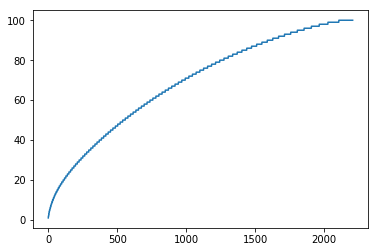

In [10]:
# Running PCA in this dataset.
pca = PCA().fit(data)

cum_variance = np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.plot(cum_variance)
plt.show()

In [11]:
# Selecting the best number of components.
n_components = np.argmax(cum_variance > 70) + 1
print("Selected n_components: {}".format(n_components))

# Transforming the data.
transformed_data = PCA(n_components).fit_transform(data)
print("New transformed data shape: {}".format(transformed_data.shape))

Selected n_components: 995
New transformed data shape: (19924, 995)


2 clusters: Cost 13756.33; Silhouette avg 0.00937; Calinski-Harabasz Index: 150.19
4 clusters: Cost 13624.72; Silhouette avg 0.00646; Calinski-Harabasz Index: 112.24
6 clusters: Cost 13504.14; Silhouette avg 0.00820; Calinski-Harabasz Index: 104.08
8 clusters: Cost 13424.97; Silhouette avg 0.00739; Calinski-Harabasz Index: 91.80
10 clusters: Cost 13367.56; Silhouette avg 0.00721; Calinski-Harabasz Index: 81.51
15 clusters: Cost 13291.25; Silhouette avg 0.01181; Calinski-Harabasz Index: 61.09
20 clusters: Cost 13134.25; Silhouette avg 0.01004; Calinski-Harabasz Index: 58.25
25 clusters: Cost 12972.35; Silhouette avg 0.01858; Calinski-Harabasz Index: 57.51
30 clusters: Cost 12881.13; Silhouette avg 0.01535; Calinski-Harabasz Index: 52.45
35 clusters: Cost 12810.20; Silhouette avg 0.01879; Calinski-Harabasz Index: 48.57
40 clusters: Cost 12688.88; Silhouette avg 0.02095; Calinski-Harabasz Index: 47.55
45 clusters: Cost 12614.68; Silhouette avg 0.02050; Calinski-Harabasz Index: 45.01
50 cl

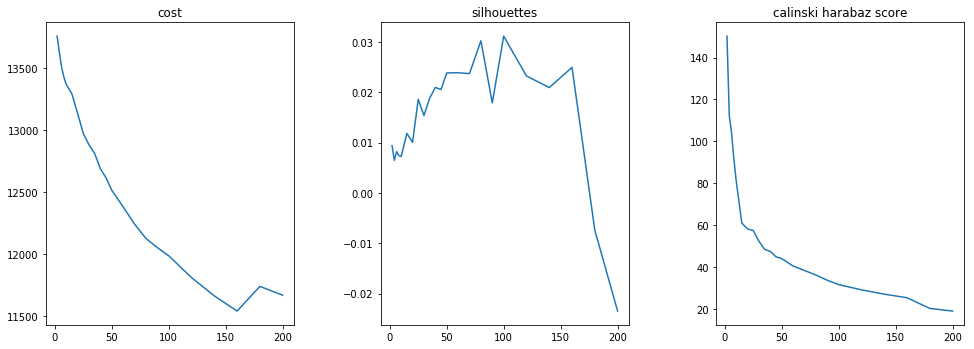

In [12]:
# Run again in transformed data
models, labels, costs, sil_avgs, ch_scores = runKmeansForMultipleCentroids(transformed_data)

In [14]:
# Chosen number of centroids
chosen_i = 17 # Meaning 100 centroids.
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
analyze_centroids(chosen_model, chosen_model_labels, transformed_data)

Chosen # of centroids: 100
Cost:                             11987.384
Silhouette avg:                       0.031
Calinski-Harabasz Index:             31.730
Selected groups: [42 64 47 14 80]


<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**1e838f8d53afd3d3bf84d6865bcab42201d8bb52**<br>Newsgroups: rec.autos<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!gatech!concert!uvaarpa!murdoch!faraday.clas.Virginia.EDU!rmt6r<br>From: rmt6r@faraday.clas.Virginia.EDU (Roy Matthew Thigpen)<br>Subject: (w)rec.autos<br>Message-ID: &lt;C5rL4H.4Kn@murdoch.acc.Virginia.EDU&gt;<br>Sender: usenet@murdoch.acc.Virginia.EDU<br>Organization: University of Virginia<br>Date: Tue, 20 Apr 1993 04:14:41 GMT<br>Lines: 3<br><br><br>There is just something disconcerting about the name of this group. :)<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**e41f1e3a54157317352d70487472b5f798cbf221**<br>Newsgroups: sci.med<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!gatech!concert!uvaarpa!murdoch!galen.med.Virginia.EDU!aj2a<br>From: aj2a@galen.med.Virginia.EDU (Amir Anthony Jazaeri)<br>Subject: Re: Heat Shock Proteins<br>Message-ID: &lt;C63r1n.8Gs@murdoch.acc.Virginia.EDU&gt;<br>Sender: usenet@murdoch.acc.Virginia.EDU<br>Organization: University of Virginia<br>References: &lt;1993Apr23.212718.10716@spruce.pfc.forestry.ca&gt;<br>Date: Mon, 26 Apr 1993 17:53:47 GMT<br>Lines: 8<br><br>by the way ms. olmstead dna is not degraded in the stomach nor<br>under pH of 2.  its degraded in the duodenum under approx.<br>neutral pH by DNAase enzymes secreted by the pancreas.  my<br>point:  check your facts before yelling at other people for not<br>doing so.  just a friendly suggestion.<br><br><br>aaj 4/26/93<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**d45a9ef6ce62ad4f53a94cae8d8176c9256b3f61**<br>Newsgroups: talk.politics.mideast<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!caen!uvaarpa!murdoch!faraday.clas.Virginia.EDU!jar2e<br>From: jar2e@faraday.clas.Virginia.EDU (Virginia's Gentleman)<br>Subject: Re: was:Go Hezbollah!!<br>Message-ID: &lt;C5HzL8.382@murdoch.acc.Virginia.EDU&gt;<br>Sender: usenet@murdoch.acc.Virginia.EDU<br>Organization: University of Virginia<br>References: &lt;1993Apr14.152612.19076@unocal.com&gt; &lt;1993Apr14.164253.22114@ncsu.edu&gt;<br>Date: Wed, 14 Apr 1993 23:51:07 GMT<br>Lines: 4<br><br>We really should try to be as understanding as we can for Brad, because it<br>appears killing is all he knows.<br><br>Jesse<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**06d946414dc155282d322bbd2795201396de914b**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:39059 alt.cad.autocad:2694<br>Newsgroups: comp.graphics,alt.cad.autocad<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!darwin.sura.net!welchgate.welch.jhu.edu!danj<br>From: danj@welchgate.welch.jhu.edu (Dan Jacobson)<br>Subject: Re: Is there an FTP achive for USGS terrain data<br>Message-ID: &lt;1993May2.151648.7673@welchgate.welch.jhu.edu&gt;<br>Organization: Johns Hopkins Univ. Welch Medical Library<br>References: &lt;1993Apr24.220701.26139@welchgate.welch.jhu.edu&gt; &lt;C6DJ25.6wL@cs.columbia.edu&gt;<br>Date: Sun, 2 May 1993 15:16:48 GMT<br>Lines: 370<br><br>In article &lt;C6DJ25.6wL@cs.columbia.edu&gt; olasov@cs.columbia.edu (Benjamin Olasov) writes:<br>&gt;In article &lt;1993Apr24.220701.26139@welchgate.welch.jhu.edu&gt; danj@welchgate.welch.jhu.edu (Dan Jacobson) writes:<br>&gt;<br>&gt;[A lot of interesting stuff about gopher - deleted]<br>&gt;<br>&gt;&gt;If you've never heard of gopher don't worry it's free and on the net,<br>&gt;&gt;write me a note if you'd like information on how to get started.<br>&gt;&gt;<br>&gt;&gt;<br>&gt;&gt;Best of luck,<br>&gt;&gt;<br>&gt;&gt;Dan Jacobson<br>&gt;&gt;<br>&gt;&gt;danj@welchgate.welch.jhu.edu<br>&gt;<br>&gt;<br>&gt;I've heard of it but lost the intro posting that came out a while back -<br>&gt;could you post it again?  I think it's of general interest.<br>&gt;<br>&gt;<br>&gt;Ben<br>&gt;-- <br>&gt;Ben Olasov		olasov@cs.columbia.edu<br><br><br><br>This is a heavily edited/modified version of the Gopher FAQ intended to<br>give people just starting with gopher enough information to get a<br>client and jump into Gopher-space - a complete version can be obtained<br>as described below.  Once you have a gopher client point it at <br>merlot.welch.jhu.edu and welcome to gopher-space!<br><br><br>Dan Jacobson<br><br>danj@welchgate.welch.jhu.edu<br><br>-----<br><br>Common Questions and Answers about the Internet Gopher, a<br>client/server protocol for making a world wide information service,<br>with many implementations.  Posted to comp.infosystems.gopher, <br>comp.answers, and news.answers every two weeks.<br><br>The most recent version of this FAQ can be gotten through gopher, or<br>via anonymous ftp:<br><br>rtfm.mit.edu:/pub/usenet/news.answers/gopher-faq<br><br>Those without FTP access should send e-mail to mail-server@rtfm.mit.edu<br>with "send usenet/news.answers/finding-sources" in the body to find out<br>how to do FTP by e-mail.<br><br>------------------------------------------------------------------- <br>List of questions in the Gopher FAQ:<br><br>Q0:  What is Gopher?<br>Q1:  Where can I get Gopher software?<br>Q2:  What do I need to access Gopher?<br>Q3:  Where are there publicly available logins for Gopher?<br>Q4:  Who Develops Gopher Software?<br>Q5: What is the relationship between Gopher and (WAIS, WWW, ftp)?<br>Q6: Are papers or articles describing Gopher available?<br>Q7: What is veronica?<br>Q8: What is Available for Biology?<br>-------------------------------------------------------------------<br>Q0:  What is Gopher?<br><br>A0:  The Internet Gopher client/server provides a distributed<br>     information delivery system around which a world/campus-wide<br>     information system (CWIS) can readily be constructed.   While<br>     providing a delivery vehicle for local information,  Gopher<br>     facilitates access to other Gopher and information servers<br>     throughout the world. <br><br>-------------------------------------------------------------------<br>Q1:  Where can I get Gopher software?<br><br>A1:  via anonymous ftp to boombox.micro.umn.edu.  Look in the directory<br>     /pub/gopher<br><br>--------------------------------------------------------------------<br>Q2:  What do I need to access Gopher?<br><br>A2:  You will need a gopher "client" program that runs on your local PC<br>     or workstation<br><br>     There are clients for the following systems.  The directory<br>     following the name is the location of the client on the anonymous<br>     ftp site boombox.micro.umn.edu (134.84.132.2) in the directory<br>     /pub/gopher.<br><br>      Unix Curses &amp; Emacs   :  /pub/gopher/Unix/gopher1.12.tar.Z<br>      Xwindows (athena)     :  /pub/gopher/Unix/xgopher1.2.tar.Z<br>      Xwindows (Motif)      :  /pub/gopher/Unix/moog<br>      Xwindows (Xview)      :  /pub/gopher/Unix/xvgopher<br>      Macintosh Hypercard   :  /pub/gopher/Macintosh-TurboGopher/old-versions <br>      Macintosh Application :  /pub/gopher/Macintosh-TurboGopher <br>      DOS w/Clarkson Driver :  /pub/gopher/PC_client/<br>      NeXTstep              :  /pub/gopher/NeXT/<br>      VM/CMS                :  /pub/gopher/Rice_CMS/ or /pub/gopher/VieGOPHER/<br>      VMS                   :  /pub/gopher/VMS/<br>      OS/2 2.0	            :  /pub/gopher/os2/<br>      MVS/XA                :  /pub/gopher/mvs/<br><br>     Many other clients and servers have been developed by others, the<br>     following is an attempt at a comprehensive list.  <br><br>      A Microsoft Windows Winsock client "The Gopher Book"<br>        sunsite.unc.edu:/pub/micro/pc-stuff/ms-windows/winsock/goph_tbk.zip<br><br>      A Macintosh Application, "MacGopher".<br>        ftp.cc.utah.edu:/pub/gopher/Macintosh <br><br>      Another Macintosh application, "GopherApp".<br>        ftp.bio.indiana.edu:/util/gopher/gopherapp <br><br>      A port of the UNIX curses client for DOS with PC/TCP<br>        oac.hsc.uth.tmc.edu:/public/dos/misc/dosgopher.exe<br><br>      A port of the UNIX curses client for PC-NFS<br>     	 bcm.tmc.edu:/nfs/gopher.exe<br><br>      A beta version of the PC Gopher client for Novell's LAN Workplace<br>      for DOS<br>         lennon.itn.med.umich.edu:/dos/gopher<br><br>      A VMS DECwindows client for use with Wollongong or UCX<br>         job.acs.ohio-state.edu:XGOPHER_CLIENT.SHARE<br><br><br>      Note: these Macintosh clients require MacTCP.<br><br>     Most of the above clients can also be fetched via a gopher client<br>     itself.  Put the following on a gopher server:<br><br>       Type=1<br>       Host=boombox.micro.umn.edu<br>       Port=70<br>       Path=<br>       Name=Gopher Software Distribution.<br><br> <br>     Or point your gopher client at boombox.micro.umn.edu, port 70 and<br>     look in the gopher directory.<br><br><br>     There are also a number of public telnet login sites available.<br>     The University of Minnesota operates one on the machine<br>     "consultant.micro.umn.edu" (134.84.132.4) See Q3 for more<br>     information about this.  It is recommended that you run the client<br>     software instead of logging into the public telnet login sites.  A<br>     client uses the custom features of the local machine (mouse,<br>     scroll bars, etc.)  A local client is also faster.<br><br>---------------------------------------------------------------------<br>Q3:  Where are there publicly available logins (ie places to telnet to<br>     in order to get a taste of gopher) for Gopher?<br><br>A3:  Here is a short list, use the site closest to you to minimize<br>     network lag.<br><br>     Telnet Public Logins:<br><br>     Hostname                  IP#              Login   Area<br>     ------------------------- ---------------  ------  -------------<br>     consultant.micro.umn.edu  134.84.132.4	gopher  North America<br>     gopher.uiuc.edu           128.174.33.160   gopher  North America<br>     panda.uiowa.edu           128.255.40.201	panda   North America<br>     gopher.sunet.se           192.36.125.2     gopher  Europe<br>     info.anu.edu.au           150.203.84.20    info    Australia<br>     gopher.chalmers.se        129.16.221.40    gopher  Sweden<br>     tolten.puc.cl             146.155.1.16     gopher  South America<br>     ecnet.ec		           157.100.45.2     gopher  Ecuador<br>     gan.ncc.go.jp             160.190.10.1     gopher  Japan<br><br><br>     It is recommended that you run the client software instead of<br>     logging into the public login sites.  A client uses the<br>     custom features of the local machine (mouse, scroll bars, etc.)<br>     and gives faster response.  Furthermore many of the basic features<br>     of clients - saving a file to your hard drive, printing a file<br>     to a local printer, viewing images, retrieving files from ftp<br>     sites etc.... are not available by the telnet logins.<br><br><br><br>---------------------------------------------------------------------<br>Q4:  Who Develops Gopher Software?<br><br>A4:  Gopher was originally developed in April 1991 by the University<br>     of Minnesota Microcomputer, Workstation, Networks Center to help<br>     our campus find answers to their computer questions.  <br><br>     It has since grown into a full-fledged World Wide Information<br>     System used by a large number of sites in the world.<br><br>     Many people have contributed to the project, too numerous to<br>     count. <br><br>     The people behind the much of the gopher software can be reached<br>     via e-mail at gopher@boombox.micro.umn.edu, or via paper mail:<br>   <br>      Internet Gopher Developers<br>      100 Union St. SE #190<br>      Minneapolis, MN 55455  USA<br><br>     Or via FAX at:<br> <br>      +1 (612) 625-6817<br><br>---------------------------------------------------------------------<br>Q5: What is the relationship between Gopher and (WAIS, WWW, ftp)?<br><br>A5: Gopher is intimately intertwined with these two other systems.<br>     As shipped the Unix gopher server has the capability to: <br>     <br>       - Search local WAIS indices.<br>       - Query remote WAIS servers and funnel the results to gopher<br>         clients.<br>       - Query remote ftp sites and funnel the results to gopher<br>         clients.<br>       - Be queried by WWW (World Wide Web) clients (either using<br>         built in gopher querying or using native http querying.<br><br>-------------------------------------------------------------------<br>Q6: Are papers or articles describing Gopher available?<br><br>A6: Gopher has a whole chapter devoted to it in :<br><br>     _The_Whole_Internet_, Ed Kroll, O'Reilly, 1992 (Editors note:<br>                             ..Great book, go out and buy a bunch!)<br><br>     _The_Internet_Passport: NorthWestNet's Guide to Our World Online"<br>     By Jonathan Kochmer and NorthWestNet. Published by NorthWestNet,<br>     Bellevue, WA. 1993. 516 pp. ISBN 0-9635281-0-6. <br>     Contact info: passport@nwnet.net, or (206) 562-3000<br><br>     _A_Students_Guide_to_UNIX by Harley Hahn. (publisher McGraw Hill,<br>     Inc.; 1993 ISBN 0-07-025511-3)<br><br><br>     Other references include:<br><br>     _The_Internet_Gopher_, "ConneXions", July 1992, Interop.<br><br>     _Exploring_Internet_GopherSpace_ "The Internet Society News", v1n2 1992, <br><br>     (You can subscribe to the Internet Society News by sending e-mail to<br>      isoc@nri.reston.va.us)<br><br>     _The_Internet_Gopher_Protocol_, Proceedings of the Twenty-Third<br>          IETF, CNRI, Section 5.3<br><br>     _Internet_Gopher_, Proceedings of Canadian Networking '92<br><br>     _The_Internet_Gopher_, INTERNET: Getting Started, SRI<br>          International, Section 10.5.5<br><br>     _Tools_help_Internet_users_discover_on-line_treasures, Computerworld,<br>          July 20, 1992<br><br>     _TCP/IP_Network_Administration_, O'Reilly.<br><br>      Balakrishan, B. (Oct 1992)<br>        "SPIGopher: Making SPIRES databases accessible through the<br>      Gopher protocol".  SPIRES Fall '92 Workshop, Chapel Hill, North<br>      Carolina.<br><br>      Tomer, C.  Information Technology Standards for Libraries,<br>      _Journal of the American Society for Information Science_,<br>      43(8):566-570, Sept 1992.<br><br><br>-------------------------------------------------------------------<br>Q7: What is veronica?<br><br>A7: veronica:  Very Easy Rodent-Oriented Net-wide Index to <br>     Computerized Archives.<br><br>     veronica offers a keyword search of most gopher-server menu titles<br>     in the entire gopher web.  As archie is to ftp archives, veronica <br>     is to gopherspace.  A veronica search produces a menu of gopher<br>     items, each of which is a direct pointer to a gopher data source.<br>     Because veronica is accessed through a gopher client, it is easy<br>     to use, and gives access to all types of data supported by the<br>     gopher protocol.<br><br>     To try veronica, select it from the "Other Gophers" menu on <br>     Minnesota's gopher server, or point your gopher at:<br><br>     Name=veronica (search menu items in most of GopherSpace) <br>     Type=1 <br>     Port=70 <br>     Path=1/veronica <br>     Host=futique.scs.unr.edu<br><br>------------------------------------------------------------------------------<br><br>Q8: What is Available for Biology?<br><br>A8: There is an incredible amount of software, data and information<br>    availble to biologists now by gopher.<br><br>Here is a brief list of the Biological Databases that you can search <br>via gopher:<br><br>      2.  BDT Tropical Data Base Searches/<br>      3.  Biotechnet Buyers Guide - Online Catalogues for Biology &lt;TEL&gt;<br>      4.  Search Protein Data Bank Headers &lt;?&gt;<br>      5.  Chlamydomonas Genetics Center /<br>      6.  Crystallization database/<br>      7.  HGMP Databases - Probes and Primers /<br>      8.  Museum of Paleontology TYPE Specimen Index &lt;?&gt;<br>      9.  MycDB - Mycobacterium DataBase &lt;?&gt;<br>      10. Search (Drosophila) Flybase (Indiana)/<br>      11. Search (GenBank + SWISS-PROT + PIR + PDB)  &lt;?&gt;<br>      12. Search AAtDB -  An Arabidopsis thaliana Database &lt;?&gt;<br>      13. Search ACEDB - A Caenorhabditis elegans Database &lt;?&gt;<br>      14. Search CompoundKB - A Metabolic Compound Database &lt;?&gt;<br>      15. Search Databases at Welchlab (Vectors, Promoters, NRL-3D, EST, OMI../<br>      16. Search EMBL &lt;?&gt;<br>      17. Search GenBank &lt;?&gt;<br>      18. Search Genbank - 2 &lt;?&gt;<br>      19. Search Genbank Updates &lt;?&gt;<br>      20. Search LiMB &lt;?&gt;<br>      21. Search PIR  &lt;?&gt;<br>      22. Search PIR (keyword,species...) &lt;?&gt;<br>      23. Search PROSITE &lt;?&gt;<br>      24. Search Rebase - Restriction Enzyme Database &lt;?&gt;<br>      25. Search SWISS-PROT &lt;?&gt;<br>      26. Search TFD &lt;?&gt;<br>      27. Search the C. elegans Strain List  &lt;?&gt;<br>      28. Search the DNA Database of Japan &lt;?&gt;<br>      29. Search the EC Enzyme Database  &lt;?&gt;<br>      30. Search the GrainGenes database  &lt;?&gt;<br>      31. Search the Maize Database /<br>      32.  Cloning Vectors: plasmids, phage, etc. &lt;?&gt;<br>      33.  EPD - Eukaryotic Promoter Database &lt;?&gt;<br>      34.  EST - Expressed Sequence Tag Database - Human &lt;?&gt;<br>      35.  wEST - Expressed Sequence Tag Database - C. elegans &lt;?&gt;<br>      36.  Kabat Database of Proteins of Immunological Interest &lt;?&gt;<br>      37.  NRL_3D Protein Sequence-Structure Database &lt;?&gt;<br>      38.  OMIM - Online Mendelian Inheritance in Man &lt;?&gt;<br>      39.  Seqanalref - Sequence Analysis Bibliographic Reference Data Ban.. &lt;?&gt;<br>      40. Search Rebase - Restriction Enzyme Database &lt;?&gt;<br>      41. Search the EC Enzyme Database &lt;?&gt;<br>      42. Search The Rodent Section of Genbank &lt;?&gt;<br>      43. Database Taxonomy (Genbank, Swiss-Prot ...)/<br>      44. Retrieve Full PDB Entries by Accession Number &lt;?&gt;<br>      45. Search for All Researchers funded by NIH &lt;?&gt;<br>      46. Search for Genome Researchers funded by DOE &lt;?&gt;<br>      47. Search for Researchers funded by NSF &lt;?&gt;<br>      48. Search for Researchers funded by the USDA &lt;?&gt;<br>      49. E-mail Addresses of Crystallographers/<br>      50. E-mail Addresses of Yeast Reasearchers/<br>      51. Phonebooks Around the World/<br>      52.  Search and Retrieve Software for All Computers/<br>      53.  Search and Retrieve Macintosh Software/<br>      54.  Search and Retrieve DOS Software/<br>      55.  Search and Retrieve GNU Software/<br>      56.  Search and Retrieve Software for Biology/<br>      57.  Search for Agricultural Software/<br>      58.  Search and Retrieve Graphics Software and Data/<br>      59.  Search and Retrieve all Online Perl Scripts/<br>      60.  FTP Sites For Biology (56 archives for software and data)/<br><br><br>And the list goes on - this is just the beginning<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**aded6c7c95af6a154fc9123b53ff113413e512b6**<br>Xref: cantaloupe.srv.cs.cmu.edu sci.crypt:15176 alt.privacy:6569 alt.answers:197 sci.answers:121 news.answers:7625<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!noc.near.net!pad-thai.aktis.com!pad-thai.aktis.com!not-for-mail<br>From: ld231782@longs.lance.colostate.edu (L. Detweiler)<br>Newsgroups: sci.crypt,alt.privacy,alt.answers,sci.answers,news.answers<br>Subject: Privacy &amp; Anonymity on the Internet FAQ (1 of 3)<br>Supersedes: &lt;net-privacy/part1_733153240@GZA.COM&gt;<br>Followup-To: poster<br>Date: 16 Apr 1993 00:00:30 -0400<br>Organization: TMP Enterprises<br>Lines: 1220<br>Sender: faqserv@GZA.COM<br>Approved: news-answers-request@MIT.Edu<br>Expires: 21 May 1993 04:00:06 GMT<br>Message-ID: &lt;net-privacy/part1_734932806@GZA.COM&gt;<br>Reply-To: ld231782@longs.lance.colostate.edu<br>NNTP-Posting-Host: pad-thai.aktis.com<br>Summary: Email and account privacy, anonymous mailing and posting, <br> encryption, and other privacy and rights issues associated with use<br> of the Internet and global networks in general.<br>X-Last-Updated: 1993/03/04<br><br>Archive-name: net-privacy/part1<br>Last-modified: 1993/3/3<br>Version: 2.1<br><br><br>IDENTITY, PRIVACY, and ANONYMITY on the INTERNET<br>================================================<br><br>(c) 1993 L. Detweiler.  Not for commercial use except by permission<br>from author, otherwise may be freely copied.  Not to be altered. <br>Please credit if quoted.<br><br>SUMMARY<br>=======<br><br>Information on email and account privacy, anonymous mailing and <br>posting, encryption, and other privacy and rights issues associated<br>with use of the Internet and global networks in general.<br><br>(Search for &lt;#.#&gt; for exact section. Search for '_' (underline) for<br>next section.)<br><br>PART 1<br>====== (this file)<br><br>Identity<br>--------<br>&lt;1.1&gt; What is `identity' on the internet?<br>&lt;1.2&gt; Why is identity (un)important on the internet?<br>&lt;1.3&gt; How does my email address (not) identify me and my background?<br>&lt;1.4&gt; How can I find out more about somebody from their email address?<br>&lt;1.5&gt; Why is identification (un)stable on the internet? <br>&lt;1.6&gt; What is the future of identification on the internet?<br><br>Privacy<br>-------<br>&lt;2.1&gt; What is `privacy' on the internet?<br>&lt;2.2&gt; Why is privacy (un)important on the internet?<br>&lt;2.3&gt; How (in)secure are internet networks?<br>&lt;2.4&gt; How (in)secure is my account?<br>&lt;2.5&gt; How (in)secure are my files and directories?<br>&lt;2.6&gt; How (in)secure is X Windows?<br>&lt;2.7&gt; How (in)secure is my email?<br>&lt;2.8&gt; How am I (not) liable for my email and postings?<br>&lt;2.9&gt; How do I provide more/less information to others on my identity?<br>&lt;2.10&gt; Who is my sysadmin?  What does s/he know about me?<br>&lt;2.11&gt; Why is privacy (un)stable on the internet?<br>&lt;2.12&gt; What is the future of privacy on the internet?<br><br>Anonymity<br>---------<br>&lt;3.1&gt; What is `anonymity' on the internet?<br>&lt;3.2&gt; Why is `anonymity' (un)important on the internet?<br>&lt;3.3&gt; How can anonymity be protected on the internet?<br>&lt;3.4&gt; What is `anonymous mail'?<br>&lt;3.5&gt; What is `anonymous posting'?<br>&lt;3.6&gt; Why is anonymity (un)stable on the internet?<br>&lt;3.7&gt; What is the future of anonymity on the internet?<br><br><br>PART 2<br>====== (next file)<br><br>Resources<br>---------<br><br>&lt;4.1&gt; What UNIX programs are related to privacy?<br>&lt;4.2&gt; How can I learn about or use cryptography?<br>&lt;4.3&gt; What is the cypherpunks mailing list?<br>&lt;4.4&gt; What are some privacy-related newsgroups?  FAQs?<br>&lt;4.5&gt; What is internet Privacy Enhanced Mail (PEM)?<br>&lt;4.6&gt; What are other Request For Comments (RFCs) related to privacy?<br>&lt;4.7&gt; How can I run an anonymous remailer?<br>&lt;4.8&gt; What are references on privacy in email?<br>&lt;4.9&gt; What are some email, Usenet, and internet use policies?<br>&lt;4.10&gt; What is the MIT ``CROSSLINK'' anonymous message TV program?<br><br>Miscellaneous<br>-------------<br><br>&lt;5.1&gt; What is ``digital cash''?<br>&lt;5.2&gt; What is a ``hacker'' or ``cracker''?<br>&lt;5.3&gt; What is a ``cypherpunk''?<br>&lt;5.4&gt; What is `steganography' and anonymous pools?<br>&lt;5.5&gt; What is `security through obscurity'?<br>&lt;5.6&gt; What are `identity daemons'?<br>&lt;5.7&gt; What standards are needed to guard electronic privacy?<br><br>Issues<br>------<br><br>&lt;6.1&gt; What is the Electronic Frontier Foundation (EFF)?<br>&lt;6.2&gt; Who are Computer Professionals for Social Responsibility (CPSR)?<br>&lt;6.3&gt; What was `Operation Sun Devil' and the Steve Jackson Game case?<br>&lt;6.4&gt; What is Integrated Services Digital Network (ISDN)?<br>&lt;6.5&gt; What is the National Research and Education Network (NREN)?<br>&lt;6.6&gt; What is the FBI's proposed Digital Telephony Act?<br>&lt;6.7&gt; What other U.S. legislation is related to privacy on networks?<br>&lt;6.8&gt; What are references on rights in cyberspace?<br>&lt;6.9&gt; What is the Computers and Academic Freedom (CAF) archive?<br><br>Footnotes<br>---------<br><br>&lt;7.1&gt; What is the background behind the Internet?<br>&lt;7.2&gt; How is Internet `anarchy' like the English language?<br>&lt;7.3&gt; Most Wanted list<br>&lt;7.4&gt; Change history<br><br><br>PART 3<br>====== (last file)<br><br>Anonymizing<br>-----------<br><br>&lt;8.1&gt; What are some known anonymous remailing and posting sites?<br>&lt;8.2&gt; What are the responsibilities associated with anonymity?<br>&lt;8.3&gt; How do I `kill' anonymous postings?<br>&lt;8.4&gt; What is the history behind anonymous posting servers?<br>&lt;8.5&gt; What is the value of anonymity?<br>&lt;8.6&gt; Should anonymous posting to all groups be allowed?<br>&lt;8.7&gt; What should system operators do with anonymous postings?<br>&lt;8.8&gt; What is going on with anon.penet.fi maintained by J. Helsingius?<br><br><br>  <br><br><br>IDENTITY<br>========<br><br>_____<br>&lt;1.1&gt; What is `identity' on the internet?<br><br>  Generally, today people's `identity' on the internet is primarily<br>  determined by their email address in the sense that this is their<br>  most unchanging 'face' in the electronic realm.   This is your<br>  login name qualified by the complete address domain information,<br>  for example ``ld231782@longs.lance.colostate.edu''.  People see<br>  this address when receiving mail or reading USENET posts from you<br>  and in other situations where programs record usage.  Some obsolete<br>  forms of addresses (such as BITNET) still persist.<br><br>  In email messages, additional information on the path that a message<br>  takes is prepended to the message received by the recipient.  This<br>  information identifies the chain of hosts involved in the<br>  transmission and is a very accurate trace of its origination.  This<br>  type of identify-and-forward protocol is also used in the USENET<br>  protocol to a lesser extent.  Forging these fields requires<br>  corrupted mailing software at sites involved in the forwarding and<br>  is very uncommon.  Not so uncommon is forging the chain at the<br>  origination point, so that all initial sites in the list are faked<br>  at the time the message is created.  Tracing these messages can be<br>  difficult or impossible when the initial faked fields are names of<br>  real machines and represent real transfer routes.<br><br>_____<br>&lt;1.2&gt; Why is identity (un)important on the internet?<br><br>  The concept of identity is closely intertwined with communication,<br>  privacy, and security, which in turn are all critical aspects of<br>  computer networks. For example, the convenience of communication<br>  afforded by email would be impossible without conventions for<br>  identification.  But there are many potential abuses of identity<br>  possible that can have very severe consequences, with massive<br>  computer networks at the forefront of the issue, which can<br>  potentially either exacerbate or solve these problems.<br><br>  Verifying that an identity is correct is called `authentication',<br>  and one classic example of the problems associated with it is<br>  H.G.Well's ``War of the Worlds'' radio broadcast that fooled<br>  segments of the population into thinking that an alien invasion was<br>  in progress.  Hoaxes of this order are not uncommon on Usenet and<br>  forged identities makes them more insidious.  People and their<br>  reputations can be assaulted by forgery.<br><br>  However, the fluidity of identity on the internet is for some one of<br>  its most attractive features. Identity is just as useful as it is<br>  harmful.  A professor might carefully explain a topic until he<br>  finds he is talking to an undergraduate. A person of a particular<br>  occupation may be able to converse with others who might normally<br>  shun him.  Some prejudices are erased, but, on the other hand, many<br>  prejudices are useful!  A scientist might argue he can better<br>  evaluate the findings of a paper as a reviewer if he knows more<br>  about the authors.  Likewise, he may be more likely to reject it<br>  based on unfair or irrelevant criteria.  On the other side of the<br>  connection,  the author may find identities of reviewers useful in<br>  exerting pressure for acceptance.<br><br>  Identity is especially crucial in establishing and regulating<br>  `credit' (not necessarily financial) and `ownership' and `usage'. <br>  Many functions in society demand reliable and accurate techniques<br>  for identification. Heavy reliance will be placed on digital<br>  authentication as global economies become increasingly electronic. <br>  Many government functions and services are based on identification,<br>  and law enforcement frequently hinges on it.  Hence, employees of<br>  many government organizations push toward stronger identification<br>  structures.  But when does identification invade privacy?<br><br>  The growth of the internet is provoking social forces of massive<br>  proportions. Decisions made now on issues of identity will affect<br>  many future users, especially as the network becomes increasingly<br>  global, universal, widespread, and entrenched; and the positive or<br>  adverse affects of these actions, intended and inadvertent,  will<br>  literally be magnified exponentially.<br><br>_____<br>&lt;1.3&gt; How does my email address (not) identify me and my background?<br><br>  Your email address may contain information that influences people's<br>  perceptions of your background.  The address may `identify' you as<br>  from a department at a particular university, an employee at a<br>  company, or a government worker.  It may contain your last name,<br>  initials, or cryptic identification codes independent of both.  In<br>  the US some are based on parts of social security numbers.  Others<br>  are in the form 'u2338' where the number is incremented in the<br>  order that new users are added to the system.<br><br>  Standard internet addresses  also can contain information  on your<br>  broad geographical location or nationhood.  However, none of this<br>  information is guaranteed to be correct or be there at all.  The<br>  fields in the domain qualification of the username are based on<br>  rather arbitrary organization, such as (mostly invisible) network<br>  cabling distributions.  The only point to make is that early fields<br>  in the address are more specific (such as specific computer names<br>  or local networks) and the later ones the most general (such as<br>  continental domains).  Typically the first field is the name of the<br>  computer receiving mail.<br><br>  Gleaning information from the email address alone is sometimes an<br>  inspired art or an inconsistent and futile exercise.  (For more<br>  information, see the FAQs on email  addresses and known<br>  geographical distributions below.)  However, UNIX utilities exist<br>  to aid in the quest (see the question on this).<br><br>  Common Suffixes<br>  ---------------<br><br>  .us    United States<br>  .uk    United Kingdom<br>  .ca    Canada<br>  .fi    Finland<br>  .au    Australia<br><br>  .edu   university or college<br>  .com   commercial organization<br>  .org   'other' (e.g. nonprofit organization)<br>  .gov   government<br>  .mil   military site<br> <br>_____<br>&lt;1.4&gt; How can I find out more about somebody with a given email address?<br><br>  One simple way is to send email to that address, asking.  Another<br>  way is to send mail to the postmaster at that address (i.e.<br>  postmaster@address), although the postmaster's job is more to help<br>  find user ID's of particular people given their real name and solve<br>  mail routing problems.  The sysadmin (i.e. `root@address') may also<br>  be able to supply information.  Users with related email address<br>  may have information.  However, all of these methods rely on the<br>  time and patience of others so use them minimally.<br><br>  One of the most basic tools for determining identity over the<br>  internet is the UNIX utility 'finger'.  The basic syntax is:<br><br>    finger user@here.there.everywhere<br><br>  This utility uses communication protocols to query the computer<br>  named in the address for information on the user named.  The<br>  response is generated completely by the receiving computer and may<br>  be in any format.  Possible responses are as follows:<br><br>  - A message `unknown host' meaning some aspect of the address is<br>    incorrect, two lines with no information and '???'.<br>  <br>  - A message 'In real life: ???' in which case the receiving computer<br>    could not find any kind of a match on the username. The finger<br>    utility may return this response in other situations.<br>  <br>  - A listing of information associated with multiple users. Some<br>    computers will search only for matching user IDs, others will<br>    attempt to find the username you specified as a substring of all<br>    actual full names of users kept in a local database.<br>  <br>  At some sites 'finger' can be used to get a list of all users on the<br>  system with a `finger @address'.  In general this is often<br>  considered weak security, however, because `attackers' know valid<br>  user ID's to `crack' passwords.<br><br>  More information on the fields returned by `finger' is given below. <br>  More information on `finger' and locating people's email addresses<br>  is given in the email FAQ (such as the WHOIS lookup utility).  Just<br>  as you can use these means to find out about others, they can use<br>  them to find out about you.  You can `finger' yourself to find out<br>  what is publicly reported by your UNIX system about you.  Be<br>  careful when modifying `finger' data; virtually anyone with<br>  internet access worldwide can query this information.  In one<br>  amazing case, the New York Times writer J. Markoff uncovered the<br>  identity of R. Morris, author of the Internet Worm,  through<br>  the use of an anonymous tip and 'finger'.  See the book Cyberspace<br>  by K. Hafner and J. Markoff.<br><br>_____<br>&lt;1.5&gt; Why is identification (un)stable on the internet?<br><br>  Generally, identity is an amorphous and almost nonexistent concept<br>  on the Internet for a variety of reasons.  One is the inherent<br>  fluidity of `cyberspace' where people emerge and submerge<br>  frequently, and absences are not readily noted in the `community'. <br>  Most people remember faces and voices, the primary means of casual<br>  identification in the 'real world'.  The arbitary and cryptic <br>  sequences of letters and digits comprising most email addresses are<br>  not particularly noticeable or memorable and far from a unique<br>  identification of an individual, who may use multiple accounts on<br>  multiple machines anywhere in the world.<br><br>  Currently internet users do not really have any great assurances<br>  that the messages in email and USENET are from who they appear to<br>  be. A person's mailing address is far from an identification of an<br>  individual.  <br>  <br>  - Anyone with access to the account, e.g. they know the password,<br>    either legitimately or otherwise, can send mail with that address<br>    in the From: line.<br>  <br>  - Email addresses for an individual tend to change frequently as<br>    they switch jobs or make moves inside their organizations. <br><br>  - As part of current mailing protocol standards, forging the From:<br>    line in mail messages is a fairly trivial operation for many<br>    hackers.<br>    <br>  The status and path information prepended to messages by<br>  intermediate hosts is generally unforgeable. In general, while<br>  possible, forgeries are fairly rare on most newsgroups and in<br>  email.  Besides these pathological cases abve there are many basic<br>  problems with today's internet protocols affecting identification<br>  on the internet:<br><br>  - Internet mail standards, described in RFC-822, are still evolving<br>    rapidly and not entirely orderly.  For example, standards for<br>    mail address `munging' or `parsing' tend to vary slightly between<br>    sites and frequently mean the difference between finding<br>    addresses and bouncing mail.<br>  <br>  - Domain names and computer names are frequently changed at sites,<br>    and there are delays in the propagation of this data.<br>  <br>  - Addresses cannot be resolved when certain critical computers<br>    crash, such as the receiving computer or other computers involved<br>    in resolving names into addresses called `nameservers'. <br>  <br>  - A whole slew of problems is associated with  `nameservers'; if<br>    they are not updated they will not find name addresses, and even<br>    the operation of what constitutes `updating' has different<br>    interpretations at different sites.<br>  <br>  The current internet mailing and addressing protocols are slightly<br>  anachronistic in that they were created when the network was<br>  somewhat obscure and not widespread, with only a fraction of the<br>  traffic it now sees.  Today a large proportion of internet traffic<br>  is email, comprising  millions of messages.<br><br>_____<br>&lt;1.6&gt; What is the future of identification on the internet?<br><br>  Some new technologies and standards are introducing facial images<br>  and voice messages  into mail and these will improve the sense of<br>  community that comes from the familiarity of identification.<br>  However, they are not currently widespread, require large amounts<br>  of data transfer, standardized software, and make some compromises<br>  in privacy.<br><br>  Promising new cryptographic techniques may make 'digital signatures'<br>  and 'digital authentication' common (see below).  Also, the trend<br>  in USENET standards is toward greater authentication of posted<br>  information.  On the other hand, advances in ensuring anonymity<br>  (such as remailers) are forthcoming.  See below.<br><br><br>PRIVACY<br>=======<br><br>_____<br>&lt;2.1&gt; What is `privacy' on the internet?<br><br>  Generally, while `privacy' has multiple connotations in society and<br>  perhaps even more on the internet, in cyberspace most take it to<br>  mean that you have exclusive use and access to your account and the<br>  data stored on and and directed to it (such as email), and you do<br>  not encounter arbitrary restrictions or searches.  In other words, <br>  others may obtain data associated with your account, but not<br>  without your permission.  These ideas are probably both fairly<br>  limiting and liberal in their scope in what most internet users<br>  consider their private domains.  Some users don't expect or want<br>  any privacy, some expect and demand it.<br><br>_____<br>&lt;2.2&gt; Why is privacy (un)important on the internet?<br><br>  This is a somewhat debatable and inflammatory topic, arousing<br>  passionate opinions.  On the internet, some take privacy for<br>  granted and are rudely surprised to find it tenuous or nonexistent.<br>  Most governments have rules that protect privacy (such as the<br>  illegal search and seizure clause of the U.S. constitution, adopted<br>  by others) but have many that are antithetical to it (such as laws<br>  prohibiting secret communications or allowing wiretapping). These<br>  rules generally carry over to the internet with few specific rules<br>  governing it.  However, the legal repercussions of the global<br>  internet are still largely unknown and untested (i.e. no strong<br>  legal precedents and court cases).  The fact that internet traffic<br>  frequently passes past international boundaries, and is not<br>  centrally managed, significantly complicates and strongly<br>  discourages its regulation.<br><br>_____<br>&lt;2.3&gt; How (in)secure are internet networks?<br><br>  - `Theoretically' people at any site in the chain of sites with<br>    access to hardware and network media that transmits data over the<br>    Internet  could potentially monitor or archive it. However, the<br>    sheer volume and general 'noise' inherent to this data makes<br>    these scenarios highly improbable, even by government agencies<br>    with supposedly vast funding and resources.<br>  <br>  - Technologies exist to `tap' magnetic fields given off by<br>    electrical wires without detection.  Less obscurely, any machine<br>    with a network connection is a potential station for traffic<br>    detection, but this scenario requires knowledge and access to<br>    very low-level hardware (the network card) to pursue, if even<br>    possible.<br>  <br>  - A company Network General Inc. is one of many that manufactures<br>    and markets sophisticated network monitoring tools that can<br>    'filter' and read packets by arbitrary criteria for<br>    troubleshooting purposes, but the cost of this type of device is<br>    prohibitive for casual use.<br><br>  Known instances of the above types of security  breaches at a major<br>  scale (such as at network hubs) are very rare. The greatest risks<br>  tend to emerge locally.  Note that all these approaches are almost<br>  completely defused with the use of cryptography.<br>    <br>_____<br>&lt;2.4&gt; How (in)secure is my account?<br><br>  By default, not very.  There are a multitude of factors that may<br>  reinforce or compromise aspects of your privacy on the internet. <br>  First, your account must be secure from other users. The universal<br>  system is to use a password, but if it is `weak' (i.e. easy to<br>  guess) this security is significantly diminished.  Somewhat<br>  surprisingly and frighteningly to some, certain  users of the<br>  system, particularly the administrator, generally have unlimited<br>  access regardless of passwords, and may grant that access to<br>  others.  This means that they may read any file in your account<br>  without detection.<br><br>  Furthermore, not universally known, most UNIX systems keep fairly<br>  extensive accounting records of when and where you logged in, what<br>  commands you execute, and when they are executed (in fact, login<br>  information is usually public). Most features of this `auditing' or<br>   `process accounting' information are enabled by default after the<br>  initial installation and the system administrator may customize it<br>  to strengthen or weaken it to satisfy performance or privacy aims. <br>  This information is frequently consulted for troubleshooting<br>  purposes and may otherwise be ignored.  This data tracks<br>  unsuccessful login attempts and other 'suspicious' activities on<br>  the system. A traditional part of the UNIX system that tracks user<br>  commands is easily circumvented by the user with the use of<br>  symbolic links (described  in 'man ln').<br>  <br>  UNIX implementations vary widely particularly in tracking features<br>  and new sophisticated mechanisms are introduced by companies<br>  regularly. Typically system adminstrators augment the basic UNIX<br>  functionality with public-domain programs and locally-developed<br>  tools for monitoring, and use them only to isolate `suspicious'<br>  activity as it arises (e.g. remote accesses to the 'passwd' file, incorrect<br>  login attempts, remote connection attempts, etc.).<br>  <br>  Generally, you should expect little privacy on your account for<br>  various reasons:<br>  <br>  - Potentially, every keystroke you type could be intercepted by<br>    someone else. <br><br>  - System administrators make extensive backups that are completely<br>    invisible to users which may record the states of an account over<br>    many weeks. <br><br>  - Erased files can, under many operating systems, be undeleted. <br><br>  - Most automated services keep logs of use for troubleshooting or<br>    otherwise; for example FTP sites usually log the commands and<br>    record the domain originations of users, including anonymous<br>    ones.<br><br>  - Some software exacerbates these problems.  See the section on<br>    ``X Windows (in)security''.<br><br>  Indepedent of malevolent administrators are fellow users, a much<br>  more commonly harmful threat. There are multiple ways to help<br>  ensure that your account will not be accessed by others, and<br>  compromises can often be traced to failures in these guidelines:<br><br>  - Choose a secure password.  Change it periodically.<br>  - Make sure to logout always.<br>  - Do not leave a machine unattended for long.<br>  - Make sure no one watches you when you type your password.<br>  - Avoid password references in email.<br>  - Be conservative in the use of the .rhost file.<br>  - Use utilities like `xlock' to protect a station, but be<br>    considerate.<br><br>  Be wary of situations where you think you should supply your<br>  password.  There are only several basic situations where UNIX<br>  prompts you for a password: when you are logging in to a system or<br>  changing your password.  Situations can arise in which prompts for<br>  passwords are forged by other users, especially in cases where you<br>  are talking to them (such as Internet Relay Chat).  Also, be  aware<br>  that forged login screens are one method to illegitimately obtain <br>  passwords.<br><br><br>  (Thanks to Jim Mattson &lt;mattson@cs.ucsd.edu&gt; for contributions<br>  here.)<br><br>_____<br>&lt;2.5&gt; How (in)secure are my files and directories?<br><br>  The most important privacy considerations are related to file<br>  rights, and many lapses can be traced to their misunderstood nature<br>  or haphazard maintenance. Be aware of the rights associated with<br>  your files and directories in UNIX. If the `x' (`execute') right on<br>  your parent directory is off for users, groups, and other, these<br>  users cannot gain information on anything in your directories. <br>  Anything less may allow others to read, change, or even delete<br>  files in your home directory. The rights on a directory supersede<br>  the rights associated with files in that directory. For a<br>  directory, 'x' means that access to the files (or subdirectories)<br>  in the directory is possible -- if you know their names.  To list<br>  the contents of the directory, however, requires the 'r' right.<br> <br>  By default most accounts are accessable only to the owner, but the<br>  initial configuration varies between sites based on administrator<br>  preference.  The default file mode specifies the initial rights<br>  associated with newly created files, and can be set in the shell<br>  with `umask'.  The details of rights implementations tend to vary<br>  between versions of UNIX.  Consult man pages on `chmod' and `ls'.<br><br>  Examples<br>  --------<br><br>    traver.lance % ls -ld ~<br>    drwx------ 15 ld231782     1536 Jan 31 21:22 /users/ld231782/<br><br>  Here is a listing of the rights associated with a user's home<br>  directory, denoted by `~'.  The columns at the left identify what<br>  rights are available. The first column identifies the entry as a<br>  directory, and the next three columns mean that read, write, and<br>  execute rights, respectively, are permitted for that user.  For<br>  directories, the `x' right means that contents (file and<br>  subdirectory names) within that directory can be listed. The<br>  subsequent columns indicate that no other users have any rights to<br>  anything in the directory tree originating at that point.  They<br>  can't even `see' any lower files or subdirectories; the hierarchy<br>  is completely invisible to them.<br><br>    traver.lance % ls -l msg<br>    -rw-r--r--  1 ld231782   35661 Jan 29 23:13 msg<br>    traver.lance % chmod u=rw,g=,o= msg<br>    traver.lance % ls -l msg<br>    -rw-------  1 ld231782   35661 Jan 29 23:13 msg<br><br>  Here the modes on the file `msg' were changed to take away rights<br>  from `group' and `other'. <br>  <br>  Note that `ls -l &lt;file&gt;' requires both the 'r' right to get the list<br>  of files and subdirectories, and the 'x' right to access the files<br>  and subdirectories in order to get their size, etc. For example,<br>  suppose the directory `foo' has rights dr--r--r--,  the following<br>  is possible:<br><br>    ls foo<br><br>  These commands would fail independent of file rights:<br>  <br>    ls -l foo<br>    ls -l foo/file<br>    cat foo/file<br>    cd foo<br><br>  If the directory `foo' has rights d--x--x--x, the following are<br>  possible if it is known beforehand that `foo' contains an 'r'<br>  readable file named `file':<br>  <br>    ls -l foo/file<br>    cat foo/file<br>    cd foo<br>  <br>  The following commands fail:<br>  <br>    ls foo<br>    ls -l foo<br>  <br><br>  (Thanks to Uwe Waldmann &lt;uwe@mpi-sb.mpg.de&gt; for contributions here.)<br><br>_____<br>&lt;2.6&gt; How (in)secure is X Windows?<br><br>  X Windows is the primary software developed by the MIT Athena<br>  project which is funded by U.S. government grants to develop<br>  applications to harness the power of networks in enhancing<br>  computational tasks, particularly the human-computer interface. <br>  The software implements a client-server interface to a computer via<br>  graphical windows. In this case the `client' is the application<br>  requesting or utilizing  graphical resources (such as windows or a<br>  mouse) and the `server' is the machine that provides them.  In many<br>  situations the client is an application program running on the same<br>  machine as the server.<br><br>  The great utility of X Windows comes from its complete dissociation<br>  of the client and server so that windows may be `broadcast' to a<br>  server at a remote location from the  client. Unfortunately this<br>  dynamic power also introduces many deep, intricate, and complicated<br>  security considerations.  The primary security and privacy issue<br>  associated with X Windows is that much more sensitive data may be<br>  sent over a network, and over wider regions, than in the case where<br>  the human is situated near the host computer.  Currently there is<br>  no encryption of data such as screen updates and keystrokes in X<br>  Windows.<br><br>  Due to either intentional design decisions or unintentional design<br>  flaws,  early versions of the X Window system are extremely<br>  insecure. Anyone with an account on the server machine can disrupt<br>  that display or read it electronically based on access to the<br>  device unix:0.0 by any regular user.   There are no protections<br>  from this type of access in these versions.   The problem arises<br>  because the security is completely based on machine addresses<br>  rather than users, such that any user at a `trusted' machine is<br>  himself trusted. Quoting from X documentation (man Xsecurity):<br>  <br>  &gt; Any client on a host in the host access control list is allowed<br>  &gt; access to the X server. This system can work reasonably well in<br>  &gt; an environment where everyone trusts everyone, or when only a<br>  &gt; single person can log into a given machine...This system does not<br>  &gt; work well when multiple people can log in to a single machine and<br>  &gt; mutual trust does not exist. <br>  <br>  With the access control list, the `xhost' command may prevent some<br>  naive attempts (i.e. those other than the direct-access unix:0.0<br>  evasion); the syntax as typed on the host machine is  ``xhost<br>  +[name]'' where [name] is the domain name or internet address of an<br>  authorized client machine. By default clients running nonlocal to<br>  the host are disabled.  Public domain programs to disrupt a display<br>  momentarily (such as 'flip' or slowly mirror the screen image, or<br>  cause pixels to 'melt' down to the bottom) have been circulating on<br>  the internet among hackers for several years and played as pranks<br>  on unsuspecting or inexperienced users.  Much more serious security<br>  breaches are conceivable from similar mechanisms exploiting this<br>  inherent weaknesses.  (The minimal, easily-bypassed `trusted'<br>  security mode of `xhost' has been jokingly referred to as ``X<br>  Hanging Open, Security Terrible.''). <br><br>  New versions of the X Window system (X11R5 and higher) by default <br>  make server access as secure as the file system using a .Xauthority<br>  file and 'magic cookies'.  Remote machines must have a code in the<br>  .Xauthority file in the home directory that matches the code<br>  allowed by the server.  Many older programs and even new<br>  vendor-supplied code does not support or is incompatible with<br>  `magic cookies'. The basic magic cookie mechanism is vulnerable to<br>  monitoring techniques described earlier because no encryption of<br>  keys occurs in transmission.  X11R5 also includes other<br>  sophisticated encryption mechanisms.  Try `man Xsecurity' to find<br>  out what is supported at your site.  Even though improved security <br>  mechanisms have been available in X Windows since ~1990, local<br>  sites often update this software infrequently because installation<br>  is extremely complex.<br><br><br>  (Thanks to Marc Vanheyningen &lt;mvanheyn@whale.cs.indiana.edu&gt;, <br>  Jim Mattson &lt;mattson@cs.ucsd.edu&gt;, and Bill Marshall<br>  &lt;marshall@cs.iastate.edu&gt; for contributions here.)<br><br>_____<br>&lt;2.7&gt; How (in)secure is my email?<br><br>  By default, not very.  The characters that you are reading are<br>  almost certainly encoded in ASCII, the American Standard Code for<br>  Information Interchange that maps alphabetic and symbolic<br>  characters onto numeric codes and vice versa.  Virtually every<br>  computer system uses this code, and if not, has ways of converting<br>  to and from it.  When you write a mail message, by default it is<br>  being sent in ASCII,  and since the standard is virtually<br>  universal, there is no intrinsic privacy.  Despite milleniums worth<br>  of accumulated cryptographic knowledge, cryptographic technologies<br>  are only recently being established that afford high priority to<br>  privacy as a primary criteria in computer and network design.  Some<br>  potential pitfalls in privacy are as follows:<br><br>  - The most serious threats are instances of immature or unscrupulous<br>    system operators reading private mail in the `spool files' at a<br>    local site (i.e. at the source or destination of the message),<br>    such as a university. <br>  <br>  - System administrators may also release files to law enforcement<br>    agencies, but conventions and protocols for warrants involving<br>    computer searches have still not been strongly established and<br>    tested legally.<br><br>  - Note that bounced messages go to postmasters at a given site in<br>    their entirety.  This means that if you address mail with an<br>    incorrect address it has a good chance of being seen by a human<br>    other than the recipient.<br><br>  - Typically new user accounts are always set up such that the local<br>    mail directory is private, but this is not guaranteed and can be<br>    overridden.<br><br>  - Finally, be aware that some mailing lists (email addresses of <br>    everyone on a list) are actually publicly accessable via mail <br>    routing software mechanisms.  This `feature' can be disabled.<br><br>  Most potential compromises in email privacy can be thoroughly<br>  avoided with the use of strong end-to-end cryptography, which has<br>  its own set of caveats (for example, unscrupulous administrators<br>  may still be a threat if the encryption site is shared or<br>  nonlocal).  See the sections on ``email privacy'' and ``email<br>  policies.''<br><br>_____<br>&lt;2.8&gt; How am I (not) liable for my email and postings?<br><br>  As punishment or whatever, your system administrator can revoke<br>  certain `privileges' such as emailing, USENET posting or reading<br>  certain groups, file transferring, remote communications, or<br>  generally any subset of capabilities available from your account. <br>  This all is completely at the discretion of the local administrator<br>  and under the procedures followed at a particular site, which in<br>  many cases are haphazard and crisis-oriented.  Currently there are<br>  virtually no widespread, uniform guidelines or procedures  for<br>  restricting use to any internet services, and local administrators<br>  are free to make arbitrary decisions on access.<br><br>  Today punitive measures are regularly applied in various situations.<br>  In the typical scenario complaint(s) reach a system adminstrator<br>  regarding abuses by a user, usually but not necessarily preceded by<br>  complaints to the user in email, regarding that person's<br>  objectionable email or postings.  `abusive' posters to USENET are<br>  usually first given admonitions from their system administrators as<br>  urged by others on the `net'. (The debate persists endlessly on<br>  many newsgroups whether this is also used  as a questionable means<br>  of attacking or silencing `harmless crackpots' or censoring<br>  unpopular opinions.)<br>  <br>  System administrators at remote sites regularly cooperate to<br>  'squelch' severe cases of abuse.  In general, however, by tradition<br>  Usenet readers are remarkably tolerant of diverse views and uses of<br>  the system, but a colorful vocabularly of slang helps describe<br>  their alternatives when this patience is sapped: the options<br>  wielded by the individual user are to simply advance to the next<br>  message (referred to as ``hitting the `n' key''), or to `plonk'<br>  annoying posters (according to the Hacker's Dictionary, the sound a<br>  jerk makes at the end of a fall to the bottom of a kill file).<br><br>  In cases where punitive actions are applied, generally system<br>  administrators are least likely to restrict email.  USENET postings<br>  are much more commonly restricted, either to individual users or <br>  entire groups (such as a university campus).  Restrictions are most<br>  commonly associated with the following `abuses':<br><br>  - harassing or threatening notes, `email terrorism'<br>  - illegal uses, e.g. piracy or propagation of copyrighted material<br>  - `ad hominem' attacks, i.e. insulting the reputation of the<br>    poster instead of citing the content of the message<br>  - intentional or extreme vulgarity and offensiveness<br>  - inappropriate postings, esp. binary files in regular groups<br>    `mail-bombing': inundating mail boxes with numerous or massive<br>    files<br><br>  Major problems originate from lack of distinctions in private and<br>  official email or postings.  Most users have internet access via<br>  accounts at businesses or universities and their activities on the<br>  internet can be construed as representative of their parent<br>  organizations. Many people put disclaimers in their `signatures' in<br>  an attempt dissociate their identity and activities from parent<br>  organizations as a precaution. A recent visible political case<br>  involves the privacy of electronic mail  written by White House<br>  staff members of the Bush administration.  Following are some<br>  guidelines:<br><br>  - Acquaint yourself with your company or university policy.<br>  - If possible, avoid use of your company email address for private<br>    communication.<br>  - Use a disclaimer.<br>  - Keep a low profile (avoid `flamewars' or simply don't post).<br>  - Avoid posting information that could be  construed to be<br>    proprietary or `internal'.<br><br>  The following references are available from ftp.eff.com<br>  (see also the section on ``internet use policies''):<br><br>  /pub/academic/banned.1991<br>  /pub/academic/banned.1992<br>  ---<br>    Computer material that was banned/challenged in academia in 1991<br>    and 1992 including USENET hierarchies.<br><br>  /pub/academic/cases<br>  ---<br>    This is an on-line collection of information about specific<br>    computers and academic freedom cases. File README is a detailed<br>    description of the items in the directory.<br><br>  /pub/academic/faq/netnews.liability<br>  ---<br>    Notes on university liability for Usenet.<br><br>_____<br>&lt;2.9&gt; How do I provide more/less information to others on my identity?<br><br>  The public information of your identity and account is mostly<br>  available though the UNIX utility `finger' described above. <br>  <br>  - You have control over most of this information with the utility<br>    `chfn', the specifics vary between sites (on some systems use<br>    `passwd -f').<br>   <br>  - You can provide unlimited information in the .plan file which is<br>    copied directly to the destination during the fingering. <br>    <br>  - A technique that works at some sites allows you to find out who is<br>    'finger'ing you and even to  vary the .plan file sent to them.<br>    <br>  - Your signature is determined by the environment variable SIGNATURE<br>    <br>  - USENET signatures are conventionally stored in the .signature file<br>    in your home directory.<br>    <br>  Providing less information on your online identity is more difficult<br>  and involved.  One approach is to ask your system adminstrator to<br>  change or delete information about you (such as your full name). <br>  You may be able to obtain access on a public account or one from<br>  someone unrelated to you personally.  You may be able to remotely<br>  login (via modem or otherwise) to computers that you are not<br>  physically near.  These are tactics for hiding or masking your<br>  online activities but nothing is foolproof.  Consult man pages on<br>  the 'chmod' command and the default file mode.  Generally, files on<br>  a shared system have good safeguards within the user pool but very<br>  little protection is possible from corrupt system administrators.<br><br>  To mask your identity in email or on USENET you can use different<br>  accounts. More untraceable are new `anonymous posting' and<br>  remailing services that are very recently being established.  See<br>  below.<br><br>______<br>&lt;2.10&gt; Who is my sysadmin?  What does s/he know about me?<br><br>  The requirements and screening for getting a system administration<br>  job (and thereby access to all information on a system) vary widely<br>  between sites and are sometimes frighteningly lax, especially at<br>  universities.  Many UNIX systems at universities are largely<br>  managed by undergraduates with a background in computing and often<br>  `hacking'.  In general, commercial and industrial sites are more<br>  strict on qualifications and background, and government sites are<br>  extremely strict.<br><br>  The system adminstrator (root user) can monitor what commands you<br>  used and at what times.  S/he may have a record (backups) of files<br>  on your account over a few weeks. S/he can monitor when  you send<br>  email or post USENET messages, and potentially read either.  S/he<br>  may have access to records indicating what hosts you are using,<br>  both locally and elsewhere.  Administrators sometimes employ<br>  specialized programs to  track `strange' or `unusual' activity,<br>  which can potentially be misused.<br><br>______<br>&lt;2.11&gt; Why is privacy (un)stable on the internet?<br><br>  For the numerous reasons listed above, privacy should not be an<br>  expectation with current use of the internet.  Furthermore, large<br>  parts of the internet are funded by the U.S. NSF (National Science<br>  Foundation) which places certain restrictions on its use (such as<br>  prohibiting commercial use).  Some high-level officials in this and<br>  other government agencies may be opposed to emerging techniques to<br>  guarantee privacy (such as encryption and anonymous services).<br><br>  Historically the major threats to privacy on the internet have been<br>  local. Perhaps the most common example of this are the widespread<br>  occurrences of university administrators refusing to carry some<br>  portion of USENET newsgroups labelled as `pornographic'. The<br>  `alternative' hierarchy in the USENET system, which has virtually<br>  no restrictions on propagation and new group creation, is<br>  frequently targeted (although this material may appear anywhere).<br><br>  From the global point of view traffic is generally completely<br>  unimpeded on the internet  and only the most egregious offenders<br>  are pursued.  For example,  verbatim transcriptions of copyrighted<br>  material (such as newspaper or magazine articles) are posted to<br>  USENET with regularity without major consequences (some email<br>  complaints may ensue).  More astonishing to some is that currently<br>  significant portions of USENET traffic, and less so internet<br>  traffic, is comprised of sexually-explicit digitized images almost<br>  entirely originating from copyrighted material (newsgroups such as<br>  `alt.sex' regularly have the  highest traffic).<br>  <br>______<br>&lt;2.12&gt; What is the future of privacy on the internet?<br><br>  Some argue that the internet currently has an adequate or<br>  appropriate level of privacy.  Others will argue that as a<br>  prototype for future global networks it has woefully inadequate<br>  safeguards.  The internet is growing to become a completely global,<br>  international superhighway for data, and this traffic will<br>  inevitably entail data such as voice messages, postal mail, and<br>  many other items of extremely personal nature. Computer items that<br>  many people consider completely private (such as their local hard<br>  drives) will literally be inches from global network connections.<br>  Also, sensitive industrial and business information is exchanged<br>  over networks currently and this volume may conceivably merge with<br>  the internet.<br>  <br>  Most would agree that, for these basic but sensitive uses of the<br>  internet, no significant mechanisms are currently in place to<br>  ensure much privacy. New standards are calling for uniform<br>  introduction of `privacy enhanced mail' (PEM) which uses encryption<br>  technologies to ensure privacy, so that privacy protection is<br>  automatic, and may significantly improve safeguards.<br><br>  The same technology that can be extremely destructive to privacy<br>  (such as with  surreptitious surveilance) can be overwhelmingly<br>  effective in protecting  it (e.g. with encryption). Some government<br>  agencies are opposed to unlimited privacy in general, and believe<br>  that it should lawfully be forfeited in cases of criminal conduct<br>  (e.g. court-authorized wiretapping).  However, powerful new<br>  technologies to protect privacy on computers are becoming<br>  increasingly popular, provoking some to say that ``the cat is out<br>  of the bag'' and the ``genie can't be put back in the bottle''.  In<br>  less idiomatic terms, they believe that the spread of strong<br>  cryptography is already underway will be socially and technically<br>  unstoppable.<br>  <br>  To date, no feasible system that guarantees both secure<br>  communication and government oversight has been proposed (the two<br>  goals are largely incompatible). Proposals for ``registration'' of<br>  secret keys (by D. Denning on sci.crypt, for example) have been met<br>  with hot controversy at best and ridicule and derision at worst,<br>  mainly because of concerns for the right to privacy and objections<br>  of inherent feasibility.  Electronic privacy issues, and<br>  particularly the proper roles of networks and the internet, will<br>  foreseeably become highly visible and explosive over the next few<br>  years.<br><br><br>ANONYMITY<br>=========<br><br>_____<br>&lt;3.1&gt; What is `anonymity' on the internet?<br><br>  Simply stated, anonymity is the absence of identity, the<br>  ultimate in privacy. However, there are several variations on<br>  this simple theme.  A person may wish to be consistently<br>  identified by a certain pseudonym or `handle' and establish a<br>  reputation under it in some area, providing pseudo-anonymity.<br>  A person may wish to be completely untraceable for a single<br>  one-way message (a sort of `hit-and-run'). Or, a person may<br>  wish to be openly anonymous but carry on a conversation with<br>  others (with either known or anonymous identities) via an<br>  `anonymous return address'.  A user may wish to appear as a<br>  `regular user' but actually be untraceable.  Sometimes a user<br>  wishes to hide who he is sending mail to (in addition to the<br>  message itself). The anonymous item itself may be directed at<br>  individuals or groups.  A user may wish to access some<br>  service and hide all  signs of the association. <br>  <br>  All of these uses are feasible on the internet but are currently<br>  tricky to carry out in practice, because of all the tracking<br>  mechanisms inherent to operating systems and network protocols. <br>  Officials of the NSF and other government agencies may be opposed<br>  to any of these uses because of the potential for abuse. <br>  Nevertheless, the inherent facelessness of large networks will<br>  always guarantee a certain element of anonymity.<br><br>_____<br>&lt;3.2&gt; Why is `anonymity' (un)important on the internet?<br><br>  Anonymity is another powerful tool that can be beneficial or<br>  problematic depending on its use.  Arguably absence of<br>  identification is important as the presence of it.  It may be the<br>  case that many strong benefits from electronic anonymity will be<br>  discovered that were unforeseen and unpredicted, because true<br>  anonymity has been historically very difficult to establish.<br><br>  One can use anonymity to make personal statements to a colleague<br>  that would sabotage a relationship if stated openly (such as<br>  employer/employee scenarios).  One can use it to pass information<br>  and evade any threat of direct retribution.  For example,<br>  `whistleblowers' reporting on government abuses (economic, social,<br>  or  political) can bring issues to light without fear of stigma or<br>  retaliation. Sensitive, personal, potentially damaging information<br>  is often posted to some USENET groups, a risky situation where<br>  anonymity allows conversations to be carried on completely<br>  independent of the identities of the participants.  Some police<br>  departments run phone services that allow anonymous reporting of<br>  crimes; such uses would be straightforward on the network.<br>  Unfortunately, extortion and harassment become more insidious with<br>  assurances of anonymity.<br><br>_____<br>&lt;3.3&gt; How can anonymity be protected on the internet?<br><br>  The chief means, as alluded to above, are masking identities in<br>  email and posting. However, anonymous accounts (public accounts as<br>  accessable and anonymous as e.g. public telephones) may be<br>  effective as well, but this use is generally not officially<br>  supported and even discouraged by some system adminstrators and NSF<br>  guidelines.  The nonuniformity in the requirements of obtaining<br>  accounts at different sites and institutions makes anonymous<br>  accounts generally difficult to obtain to the public at large.<br><br>  Many communications protocols are inherently detrimental to<br>  anonymity.  Virtually every protocol in existence currently<br>  contains information on both sender and receiver in every packet.<br>  New communications protocols will likely develop that guarantee<br>  much higher degrees of secure anonymous communication.<br><br>_____<br>&lt;3.4&gt; What is `anonymous mail'?<br><br>  One approach to `anonymizing' mail has been to set up an `anonymous<br>  server' that, when activated by email to its address, responds by<br>  allocating and supplying an `anonymous ID' that is unique to the<br>  person requesting it (based on his email address).  This will vary<br>  for the same person for different machine address email<br>  originations. To send anonymous mail, the user sends email directed<br>  to the server containing the final destination. The server<br>  `anonymizes' the message by stripping of identification information<br>  and forwards the message, which appears to originate from the<br>  anonymous server only from the corresponding anonymous user id. <br>  This is the `interactive' use of anonymity or pseudonymity<br>  mentioned above.<br><br>  Another more `fringe' approach is to run a `cypherpunk' remailer<br>  from a regular user account (no root system privileges are<br>  required). These are currently being pioneered by  Eric Hughes and<br>  Hal Finney &lt;hal@alumni.caltech.edu&gt;. The operator runs a process on<br>  a machine that anonymizes mail sent to him with certain<br>  characteristics that distinguish it from his regular incoming mail<br>  (typically fields in the header). One has been implemented as a <br>  PERL script running on UNIX.  Several of these are in existence<br>  currently but sites and software currently are highly unstable;<br>  they may be in operation outside of system administrator knowledge.<br>  The remailers don't generally support anonymous return addresses. <br>  Mail that is incorrectly addressed is received by the operator. <br>  Generally the user of the remailer has to disavow any<br>  responsibility for the messages forwarded through his system,<br>  although actually may be held liable regardless.<br><br>  These approaches have several serious disadvantages and weaknesses:<br>  <br>  - The anonymous server approach requires maintaining a mapping of<br>    anonymous ID's to real addresses that must be maintained<br>    indefinitely.  One alternative is to allow `deallocation' of<br>    aliases at the request of the user, but this has not been<br>    implemented yet.<br><br>  - Although an unlikely scenario, traffic to any of these sites could<br>    conceivably be monitored from the `outside', necessitating the<br>    use of cryptography for basic protection,.<br><br>  - Local administrators can shut them down either out of caprice or<br>    under pressure from local, network, or government agencies.<br>  <br>  - Unscrupulous providers of the services can monitor the traffic<br>    that goes through them.<br><br>  - Most remailers currently keep logs that may be inspected. <br><br>  - The cypherpunk approach tends to be highly unstable because these<br>    operators are basically  network users who do not own the<br>    equipment and are accountable  to their own system<br>    administrators, who may be unaware of the use and unsympathetic<br>    to the philosophy of anonymity when the operation is discovered,<br>    regarding it as illicit use. <br><br>  - In all cases, a high degree of trust is placed in the anonymous<br>    server operator by the user.<br><br>  Currently the most direct route to anonymity involves using SMTP<br>  protocols to submit a message directly to a server with arbitrary<br>  field information.  This practice, not uncommon to hackers, and the<br>  approach used by remailers, is generally viewed with hostility by<br>  most system administrators.  Information in the header routing data<br>  and logs of network port connection information may be retained<br>  that can be used to track the originating site.  In practice, this<br>  is generally infeasible and rarely carried out.  Some<br>  administrators on the network will contact local administrators to<br>  request a message be tracked and its writer admonished or punished<br>  more severely (such as revoking the account), all of this actually<br>  happening occasionally but infrequently.<br><br>  See the sections ``known anonymous mail and posting sites'' and <br>  ``responsibilities associated with anonymity''.<br><br>_____<br>&lt;3.5&gt; What is `anonymous posting'?<br><br>  Anonymous servers have been established as well for anonymous Usenet<br>  posting with all the associated caveats above (monitored traffic,<br>  capricious or risky local circumstances, logging).  Make sure to<br>  test the system at least once by e.g. anonymous posting to<br>  misc.test (however some operators don't recommend this because many<br>  sites `autorespond' to test messages, possibly causing the<br>  anonymous server to allocate anonymous IDs for those machines). <br>  See the ``responsibilties associated with anonymous posting''<br>  before proceeding.<br><br>  Another direct route involves using NNTP protocols to submit a<br>  message directly to a newserver with arbitrary field information.<br>  This practice, not uncommon to hackers, is also generally viewed<br>  with hostility by most system administrators, and similar<br>  consequences can ensue.<br><br>  See the sections ``known anonymous mail and posting sites'' and <br>  ``responsibilities associated with anonymity''.<br><br>_____<br>&lt;3.6&gt; Why is anonymity (un)stable on the internet?<br><br>  As noted, many factors compromise the anonymity currently available<br>  to the general internet community, and these services should be<br>  used with great caution.  To summarize, the technology is in its<br>  infancy and current approaches are unrefined, unreliable, and not<br>  completely trustworthy.  No standards have been established and<br>  troubling situations of loss of anonymity and bugs in the software<br>  are prevalent.  Here are some encountered and potential bugs: <br>  <br>  - One  anonymous remailer reallocated already allocated anonymous<br>    return addresses. <br>  - Others passed signature information embedded in messages<br>    unaltered. <br>  - Address resolution problems resulting in anonymized mail bounced<br>    to a remailer are common.<br>  - Forgeries to the anonymous server itself are a problem,  possibly<br>    allowing unauthorized users to potentially glean anon ID - email<br>    address  mappings in the alias file.  This can be remedied with<br>    the use of passwords.<br>  - Infinite mail loops are possible with chaining remailers.<br>  <br>  Source code is being distributed, tested, and refined for these<br>  systems, but standards are progressing slowly and weakly.  The<br>  field is not likely to improve considerably without  official<br>  endorsement and action by network agencies.  The whole idea is<br>  essentially still in its infancy and viewed with suspicion and<br>  distrust by many on the internet, seen as illegitimate or favorable<br>  to criminality.  The major objection to anonymity over regular<br>  internet use  is the perceived lack of accountability to system<br>  operators, i.e. invulnerability to account restrictions resulting<br>  from outside complaints.  System adminstrators at some sites have<br>  threatened to filter anonymous news postings generated by the<br>  prominent servers from their redistribution flows.  This may only<br>  have the effect of encouraging server operators to create less<br>  characteristically detectable headers.  Probably the least<br>  problematic approach, and the most traditional to Usenet, is for<br>  individual users to deal with anonymous mail however they prefer,<br>  e.g. ignoring it or filtering it with kill files.<br>  <br>_____<br>&lt;3.7&gt; What is the future of anonymity on the internet?<br><br>  New anonymous protocols effectively serve to significantly increase<br>  safeguards of anonymity.  For example, the same mechanism that<br>  routes email over multiple hosts, thereby threatening its privacy,<br>  can also be used to guarantee it. In a scheme called `chaining' an<br>  anonymous message is passed through multiple anonymous servers<br>  before reaching a destination.  In this way generally multiple<br>  links of the chain have to be `broken' for security to be<br>  compromised. Re-encryption at each link makes this scenario even<br>  more unlikely.  Even more significantly the anonymous remailers<br>  could be spread over the internet globally so that local weaknesses<br>  (such as corrupt governments or legal wiretapping within a nation)<br>  would be more unlikely to sacrifice overall security by message<br>  tracing. However, remailers run by corrupt operators are possible.<br>  <br>  The future of anonymous services on the internet is, at this time,<br>  highly uncertain and fraught with peril. While specific groups seem<br>  to benefit significantly from anonymous posting capabilities, many<br>  feel that unlimited newsgroup scope for anonymous posting is a<br>  disruptive and dangerous idea and detracts from discussions in<br>  `serious' groups.   The introduction of unlimited group anonymity<br>  may have fundamental repercussions on Usenet conventions and<br>  distribution mechanisms such as moderated and `alt' groups have had<br>  in the past. For example, as part of new group creation, the<br>  charter may specify whether `anonymous' posting is (un)welcome. <br><br>  Nevertheless, the widespread introduction and use of anonymity may<br>  be inevitable. Based on traffic statistics, anonymous services are<br>  in huge demand. Pervasive and readily available anonymity could<br>  carry significant and unforeseen social consequences.  However, if<br>  its use is continued to be generally regarded as subversive it may<br>  be confined to the underground.  The ramifications of widespread<br>  introduction of anonymity to Usenet are still largely unknown. It<br>  is unclear whether it will provoke signficant amounts of new<br>  traffic or, instead of expansion, cause a shift where a greater<br>  portion of existing traffic is anonymized.  Conceivably the<br>  services could play a role in influencing future mainstream social<br>  acceptance of Usenet.<br><br><br>  <br><br>This is Part 1 of the Privacy &amp; Anonymity FAQ, obtained via anonymous<br>  FTP to pit-manager@mit.edu:/pub/usenet/news.answers/net-privacy/ or <br>  newsgroups news.answers, sci.answers, alt.answers every 21 days.<br>Written by L. Detweiler &lt;ld231782@longs.lance.colostate.edu&gt;.<br>All rights reserved.<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c5c2a53ecbb6111a0953dd8305ddb8f4bf4c371d**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.windows.open-look:8535 comp.windows.x:67883 alt.toolkits.xview:1961 comp.windows.x.intrinsics:1208 comp.sys.sun.apps:4217 comp.sys.sun.admin:14883<br>Newsgroups: comp.windows.open-look,comp.windows.x,alt.toolkits.xview,comp.windows.x.intrinsics,comp.sys.sun.apps,comp.sys.sun.admin<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!utnut!utzoo!sq!lee<br>From: lee@sq.sq.com (Liam R. E. Quin)<br>Subject: List of programs with OPEN LOOK User Interface<br>Message-ID: &lt;1993May9.222328.23844@sq.sq.com&gt;<br>Organization: SoftQuad Inc., Toronto, Canada<br>Date: Sun, 9 May 93 22:23:28 GMT<br>Expires: 2 Jun 1993 04:00:04 GMT<br>Lines: 576<br><br><br>Id: open-look-programs.faq,v 1.17 93/03/21 17:17:55 lee Exp Locker: lee <br><br>Contents:<br>	Subject: Applications: Application Builders<br>	Subject: Applications: Graphing Tools<br>	Subject: Applications: Utilities<br>	Subject: Applications: Other<br>	Subject: Tools: Terminal Emulators<br>	Subject: Other Commercial Applications<br>	Subject: Applications: toolkit Extensions<br>	Subject: OpenWindows 3 Ports<br>	Subject: XView 3 Ports<br>	Subject: XView 2 Ports<br>	Subject: Games (free and commercial)<br><br><br>Subject: Applications: Application Builders<br><br>Commercial: DevGuide 3.0<br>Contact: SunPICS<br>    lets you use Drag and Drop to create an OPEN LOOK application with<br>    XView, OLIT, UIT or TNT.  Very easy to use.<br><br>Free: dirt<br>    there _might_ be an OLIT port of this UI builder.<br><br>Commercial: ExoCode<br>Contact: Expert Object<br>    one of the first third-party GUI builders to support OPEN LOOK,<br>    using the XView toolkit.  It was reviewed in SunExpert magazine<br>    in 1990.<br><br>Commercial: ObjectBuilder<br>Contact: ParcPlace, Debra Frances debra@ParcPlace.COM, +1 303 440 9991<br>    uib is a user interface builder which supports building applications<br>    that support both OPEN LOOK and Motif.	It generates code for<br>    ParcPlace's OI C++ toolkit and can make use of user created<br>    subclasses.  Note: `OI' can also display an OSF/Motif GUI at runtime.<br><br>Free: wcl<br>    Uses X resources to specify an Xt widget hierarchy and actions to<br>    user-defined callbacks.  uses OLIT, Xt or Motif.<br><br>Commercial: XVT<br>Contact: XVT Systems (+1 303-443-4223)<br>    Lets you write code to a common subset of OPEN LOOK, Motif, Microsoft<br>    Windows, the Macintosh GUI, and even terminals (using curses).  You buy<br>    an XVT toolkit for each environment.<br><br><br>Subject: Applications: Graphing Tools<br><br>Free: dstool<br>    XView-based program that plots Lorenz Attractors and other chaotic things<br>    in real time.  Also includes a mathematical expression interpreter.<br>    ftp: macomb.tn.cornell.edu<br><br>Free: ACE/gr --  graph and analysis program, xvgr<br>Ftp: ftp.ccalmr.ogi.edu [129.95.72.34]; xvgr-2.09.tar.Z in /CCALMR/pub/acegr<br>    Handles x-y scatterplots, lineplots, bargraphs, FFT analysis, running<br>    averages, polynomial fits, etc.<br><br>Free: robot - a scientific graph plotting and data analysis tool <br>Contact: Robin Corbet &lt;corbet@astro.psu.edu&gt;<br>Description:<br>    Graph plotting in various styles &amp; axes; Data manipulation - arithmetic,<br>    functions, smoothing, folding, sorting; Fitting to data using Gaussians,<br>    polynomials, Lorentzians, and/or user defined functions; Annotation of<br>    graphs; log files;  Commands with loops etc.; Colour; PostScript output.<br>Ftp: astrod.astro.psu.edu (128.118.147.28) in pub/astrod<br>Ftp: files: robotx0.35.tar.Z - everything<br>Ftp: files: RobotManual.ps.Z - just the documentation.<br>Ftp: files: robot.sun4.Z  - binary built on a SPARCstation.<br>Requirements:<br>    Robot is XView based. User interface portions of code are written in<br>    'C'. Data manipulation code is written in FORTRAN. Hence a FORTRAN<br>    compiler is also required or the public domain f2c package.<br>    Alternatively, a SPARC binary is available by anonymous ftp.<br><br>Subject: Applications: Utilities<br><br>Free: boss<br>Description:<br>    An OPEN LOOK UI to the Casio BOSS scheduler<br><br>Free: props<br>Ftp: export.lcs.mit.edu /pub/R5untarred/contrib/lib/xview3/clients/props/<br>Description:<br>    This is the OpenWindows properties editor, that appears when you choose<br>    the Properties... item from the WorkSpace menu.<br><br>Free: contool<br>Ftp: from export.lcs.mit.edu<br>Description:<br>    a special-purpose console-window that can filter out or take special<br>    action on specified console messages; written by Chuck Musciano.<br>Requirements: XView<br><br>Free: faces<br>Description:<br>    displays pictures of people who have sent you electronic mail.<br>    Violates the Data Protection Act in the U.K.<br><br>Subject: Applications: Other<br><br><br>Commercial: Bimail 400<br>Contact: BIM (+32-2-759.59.25) pge@sunbim.be<br>X.400-address: C=be;A=RTT;P=BIM;O=Horizon;S=Geurts;G=Patrick<br>Notes:<br>    Bimail is a complete X.400 electronic mail system.  It consists<br>    in a user interface which gives access to all X.400 services<br>    with a consistent look and feel, a message transfer agent (MTA) system<br>    which can transfer messages over X.25, TP.4 and TCP/IP (using RFC 1006).<br>    A gateway to SMTP mail is also available.<br><br>Free: calentool<br>Description:<br>    a day/week/month/year at-a-glance calendar and almanac.<br>Ftp: export.lcs.mit.edu:/contrib/calentool2.2Xp1.tar.Z<br>Contact: Bill Randle, Tektronix, Inc. &lt;billr@saab.CNA.TEK.COM&gt;<br><br>Free: emacstool<br>Description:<br>    a SunView program that was converted to XView, and is included with the<br>GNU emacs distribution.<br><br>Free: Genix<br>Contact: Ian Darwin &lt;ian@sq.com&gt;<br>    A genealogy program, written in C using Guide.<br>    Incomplete as of Jan '93; inquire for details.<br><br>Free: WorkMan - Audio CD player for X11 (Sun, Ultrix)<br>Requirements: XView libraries<br>Ftp: Ultrix binary: ftp.hyperion.com in /WorkMan<br>Ftp: ftp.ucsc.edu in "incoming" - database of over 750 CDs<br>Contact: koreth@hyperion.com (Steven Grimm)<br><br>Free: pan - Postit notes<br><br>Free: WAIS<br>Ftp: sunsite.unc.edu<br>Description:<br>    Networked, distributed text-retrieval system.  OLIT-based front end.<br>Notes:<br>    You might to need to add -lce to the Makefile.<br><br>Free: xrolo - Rolodex card index/address book<br><br>Free: xv_display<br>Description:<br>    An XView program for showing a text file, like more(1).<br><br>Commercial:  SearchIt 1.0<br>Contact: SunSoft or SunExpress <br>    US: 1-800-873-7869;  UK: 0800 89 88 88<br>    Germany: 01 30 81 61 91;  France: 05 90 61 57<br>Platforms: SPARC, Solaris 1.x<br>Price: 249<br>Notes:<br>    SearchIt is a full text search and retrieval application designed to<br>    improve individual and group productivity.  It makes an index to files<br>    and can later retrieve documents by words or phrases, ranking the results<br>    in relevance order.<br><br>Commercial: ShowMe<br>Contact: SunSoft<br>Notes:<br>    Conferencing software that lets multiple connected users share the same<br>    drawing screen, with bitmap capture and moveable pointer.<br>Requirements:<br>    You can only run one ShowMe per computer, so you have to have a CPU per<br>    conference member.<br><br>Free: xvman - Man Pages viewer<br><br>Free: xvtdl - ToDo List manager<br>Ftp: export.lcs.mit.edu /contrib/xvtdl-4.0.tar.Z, /contrib/xvtdl-4.0-README<br>Requirements: XView libraries<br>Contact: Mike Jipping jipping@cs.hope.edu  (BITNET: JIPPING@HOPE)<br>Organisation: Hope College Department of Computer Science<br>     <br>Free: name_finder<br>Contact: richard.elling@eng.auburn.edu     +1 (205) 844-2280<br>Ftp: ftp.eng.auburn.edu [131.204.10.91] pub/name_finder1.2.tar.Z.<br>Patches: pub/name_finder1.2.compile.patch1.<br>Requirements: OpenWindows 3.0, C++ 2.1 or greater to recompile<br>Description:<br>    name_finder was orginally designed as a replacement for the name finder<br>    missing from the OpenWindows Version 3.0 mailtool.  It has since grown<br>    into a tool for several electronic mail related activities including:<br>    interaction with local ListServ robots for handling mail lists,<br>    requesting Full.Name style mail aliases from your local PostMaster, and<br>    providing mailbox status information ala finger(1).<br><br>    name_finder is written in C++ (cfront 2.1) using gxv++ version 1.1.<br>    If you don't have access to a C++ compiler, a precompiled sparc<br>    executable is included in the distribution.<br><br>Free: bibcard	interface for BiBTeX databases<br>Requirements: XView<br>Ftp: iamsun.unibe.ch [130.92.64.10] in /X11/Bibcard-1.11.tar.Z<br>Ftp: 	includes source and SPARC binary for SunOS 4.1.1.<br>Version: 1.11<br>Description:<br>    GUI for mantaining bibliography databases which can be used with<br>    LaTeX, TeX and FrameMaker<br><br><br>Free: moxftp -- interface to ftp.<br>Ftp: ftp.chpc.utexas.edu as file /packages/X/xftp.1.1.tar.Z.<br>Contact: Bill Jones jones@chpc.utexas.edu<br>Requirements: X11, OLIT or Motif or Athena widgets<br>Notes:<br>    formerly called xftp.<br>    compiles under (at least) Ultrix, AIX 3.1.5, AIX 3.2, Convex OS, SunOS,<br>    Unicos 6.1.4, and IRIX.  Uses OLIT.<br>    BUG: can also use OSF/Motif and Athena widgets.<br><br><br>Free: olvwm -- OPEN LOOK Virtual Window Manager<br>contact: Scott Oaks<br>Ftp: export.lcs.mit.edu in the contrib directory<br>Patches: there are two patches<br>Requirements: XView 3<br>Description:<br>    Olvwm is a version of olwm that manages a `virtual desktop' (hence the<br>    `v' in its name).  It shows a little map on the screen, with the<br>    currently displayed area represented by a little rectangle.	 You can<br>    move around by dragging the rectangle or with the arrow keys.  This<br>    lets you run several clients (applications) and move the display around<br>    from one to the other.  Olvwm was derived from the OpenWindows 3.0 olwm.<br><br>Free: ftptool -- OPEN LOOK front-end to ftp<br>Requirements: XView<br>Ftp: export.lcs.mit.edu in /contrib<br><br>Free: Hyperlook<br>Contact: The Turing Institute<br>Requirements: OpenWindows 3 (running the xnews server, not X11)<br>    Hypertext package written entirely in NeWS.  Runtime from turing.com<br>    in /pub or ftp.uu.net (graphics/NeWS/HyperLook1.5-runtime.tar.Z)<br><br>Maestro (ftp from sioux.stanford.edu)<br>    Multimedia authoring tools, including support for sound, text &amp; video.<br>xvnews (ftp from export.lcs.mit.edu)<br>    An xview-based newsreader for netnews.<br><br>Free: xvttool<br>Ftp: cs.dal.ca:/pub/comp.archives<br>Ftp: nuri.inria.fr:/X/contrib/clients<br>Ftp: lth.se:/pub/netnews/alt.sources/volume92/dec/xvttool.Z<br>Ftp: src.doc.ic.ac.uk:/usenet/comp.archives/x11/terminal/xvttool<br>Description:<br>    A vt100/102 emulator, in both XView and SunView versions.  Includes<br>    buttons for the PF keys, etc.<br><br>Subject: PostScript and Graphics Viewers<br><br>Commercial: pageview - PostScript previewer<br>Contact: Included in OpenWindows as part of DeskSet.<br>Notes:<br>    Type 1 support only in OpenWindows 3.0.1 under Solaris 2.1.<br>    Antialiasing support - with colour OpenWindows 3 try pageview -aa -dpi 150<br>    Note that pageview uses the X11/NeWS server to interpret the PostScript,<br>    and thus won't run on an X terminal or other non-OpenWindows server.<br>    It's not enough to be runing an OPEN LOOK UI [tm] window manager such<br>    as olwm.<br><br>Commercial: xps - PostScript program editor and previewer<br>Contact: included with OpenWindows 2.0 under demo and share/src<br>Notes:<br>    Only runs under OpenWindows 2.<br><br>Commercial: psh<br>Contact: included with OpenWindows<br>	simple interface to NeWS and the OpenWindows server<br><br>Free: ralpage<br>Ftp: export.lcs.mit.edu in contrib/clients<br>Notes:<br>    Crispin Goswell's PostScript interpreter, much hacked.<br>    Not OPEN LOOK compliant.  No Type 1 font support.<br>    There are other versions of this called `xps', `postscript', etc.;<br>    don't confuse this `xps' with the one mentioned above.<br><br>Free: ghostscript<br>(from the Free Software Foundation)<br>    Supports Type 1 fonts.  Not OPEN LOOK based.<br><br><br>Subject: Tools: Terminal Emulators<br><br>Free: cmdtool, shelltool<br>Requirements: XView 3 toolkit<br>Notes:<br>    These are included in the XView source distribution from<br>    export.lcs.mit.edu in /contrib; they're also included with Sun's<br>    OpenWindows.<br><br>Commercial: SwitchTerm<br>Contact: Micro Resources Inc., Columnbus, Ohio, USA, +1 614 766-2335<br>Notes:<br>    A version of Xterm with an OPEN LOOK UI, print interface,<br>    ANSI X3.64 colour escape sequences, etc.<br><br>Commercial: IsoTerm<br>Contact: The Bristol Group Ltd., +1 415 925-9250 and (49) 6105-2945 (Germany)<br>Requirements: OpenWindows 3 (??)<br>Other Products: IsoTeX, IsoFax, Power Base<br>Notes:<br>    An OLIT-based terminal emulator.  I couldn't get the demo version to<br>    give me a shell prompt, although it did look like it was a pretty fll<br>    vt340 emulation, with double-height characters, colour, fonts, grahics<br>    and so forth.<br>    With the Union Flag (the British flag) as their logo I somehow expected<br>    an English address, perhaps in Bristol...<br><br>Subject: Other Commercial Applications<br><br>    Contact SunSoft (or Sun) and ask for the Catalyst OPEN LOOK guide,<br>    which lists over 200 pages of applications.<br><br>    You can also get the free CDWare CD/ROM, which contains demo versions<br>    of several popular OPEN LOOK UI applications.  Once you've done this,<br>    you can often simply contact the vendor concerned to have the license<br>    upgraded from demo, and receive the full product documentation.<br><br><br>Product Name: Author/Editor - SGML-based text editor/word processor<br>Company Name: SoftQuad Inc., +1 416 239 4801, mail@sq.com<br>Description:<br>    Word processor or text editor that manipulates ISO 8879 SGML documents.<br>Interfaces: OPEN LOOK UI (XView), OSF/Motif, Mac, MS/Windows<br> <br><br>Subject: Applications: toolkit Extensions<br><br><br>Product Name:     Xtra XWidgets<br>Company Name:     Graphical Software Technology<br>E-Mail:           info@gst.com<br>Phone:            310-328-9338;    Fax: 310-376-6224<br>Keywords:         graphics, library, widgets, spreadsheet, help<br>Interfaces:       OPEN LOOK, Motif<br>Platforms:        SPARC, HP9000s300/400/700, IBM RS6000, Interactive 386<br>Requirements:     X11, Xt, Xol (or Xm) libraries and headers; X11<br>Price:            795/single user, 3000/network, 5000/source<br>Support-Price:    400/30 calls<br>Source-Available: yes<br>Description:<br>    The Xtra XWidget library contains a set of widgets that are subclassed<br>    from and compatible with either OLIT or Motif widgets.  The library<br>    includes widgets that implement the following: Spreadsheet, Bar Graph,<br>    Stacked Bar Graph, Line Graph, Pie Chart, XY Plot, Hypertext, Hypertext<br>    based Help System, and Data Entry Form.  Widgets have been successfully<br>    integrated with both TeleUSE from Telesoft and Builder Xcessory from<br>    ICS.  A free demo is available for any of the supported platforms.<br><br>Product Name:     XRT/Graph<br>Company Name:     KL Group<br>E-mail: sun.com!suncan!klg!info, info@klg.com<br>Phone: +1 416 594-1026<br>Description:<br>    XRT/graph is a graph object that extends the XView toolkit;  There are<br>    also Xt versions for OLIT and Motif.  XRT/graph supports line plots,<br>    scatter-plots, strip-charts, bar charts, stacking bar charts, pie charts<br>    and filled-area charts, singly and in combination.  It supports real-time<br>    updates, true Postscript output, and intelligent user feedback.  It comes<br>    with Builder, a graph prototyping tool, which supports code &amp; resource<br>    file generation.  A free demo (vmgraph) is available.<br>    There are free integration kits for UIM/X, TeleUSE, and Builder Xcessory<br>    (others in progress).<br>Availability:<br>    XRT/graph for XView and OLIT are only available on SPARC.<br>    XRT/graph for Motif is available on a dozen or so platforms.<br><br><br>Free: Slingshot XView extension<br><br>    Slingshot provides rectangles (like the Xt Intrinsics' RectObj gadget),<br>    drag-and-drop support, images, icons and text, trees, lines, arrows...<br><br>    Get it by ftp from export.lcs.mit.edu, in /contrib/SlingShot2.0.tar.Z<br>    (remember to use binary mode in ftp!).<br>    You can also get it by sending mail to archive-server@gazooch.eng.sun.com<br>    with the body of each message containing a line like<br>	send sspkg2.0 Part01 Part02<br>    going up to<br>	send sspkg2.0 Part17 Part18<br>	send sspkg2.0 DocPart01 DocPart02 DocPart03<br>	send sspkg2.0 DocPart04 DocPart05 DocPart06<br>    You can ask for one file at a time to reduce the impact on intermediate<br>    mail sites.	 Ask the mail server for help with the Subject line: "help".<br>    A human can be reached at archive-manager@gazooch.eng.sun.com.<br>    Add a line in the message<br>	path &lt;your-mail-address&gt;<br>    if you think the normal automatic reply address might not work.<br><br><br>Ada bindings for XView<br>    Sun Ada 1.1 includes among other things an Ada Source Code Generator<br>    for Devguide.  It uses the Verdix XView Ada bindings.<br>    It does not yet [July 1992] support gfm (the guide file manager).<br><br>C++ Bindings for XView<br><br>Qualix's XV++.<br><br>UIT<br><br><br>Subject: OpenWindows 3 Ports<br><br>    Sun: SPARC, SunOS 4.1<br>    Sun: SPARC, Solaris 2 (actually 3.0.1?)<br>    others: none so far...<br><br>There are said (by Sun) to be two or three ports of OpenWindows either<br>available now or in progress.  Contact Anthony Flynn at Open Vistas<br>International (anthony@ovi.com) for more information.  (originally they<br>said 35, but perhaps they meant 3.5)<br><br>OpenWindows source is available - commercially, it costs about 5,000 for<br>the server, including TypeScaler and the toolkits; deskset (filemgr etc) is<br>another 25,000; ToolTalk is 40,000 or so.<br><br><br>Subject: XView 3 Ports<br><br>What: XView 3<br>System: Apple A/UX<br>Porter: lmj@uncompaghre.jax.org (Lou Jones)<br>Ftp: encyclo.jax.org<br>Notes:<br>    The libraries and utilities (olwm, cmdtool, etc) are available for<br>    anonymous ftp from encyclo.jax.org. I used gcc 2.1 to compile the<br>    sources. If there is enough interest, I can make the diffs<br>    available.<br><br>System: Concurrent 7000 (68040 based)<br>Porter: sinan@Mtesol.boeing.com (Sinan Karasu)<br><br>System: DECStation/Ultrix<br>Porter: dscott@ittc.wec.com (Dave Scott)<br>Ftp: media-lab.media.mit.edu:~ftp/xview3-ultrix.4.2-mips.tar.Z<br>Notes:<br>    Let me stress that this is not fully tested, but seems to work<br>    pretty well.  Please let me know about any problems you find.<br>    Problems I already know about:<br>	Large buttons under any non-Sun X server (non-xnews; i.e. any<br>	standard MIT X11R[45] server) have the bottom of the button<br>	chopped off.  We're working on this one. :-)<br>    XView 3 is also available on the DEC Freeware CD, from DECUS.<br>[actually this seems not to be Dave Scott's port; please accept my apologies<br> for listing this incorrectly.  A correct entry will appear as soon as I get<br> the necessary information.  -- Lee]<br><br>System: HP 720<br>Porter: (?)<br>Ftp: tesla.ucd.ie [137.43.24.44], /pub<br>Notes:<br>    Includes HP 720 build, HP XView patch file, Xvgr.<br><br>System: HP9000/300 series<br>Porter: tjc@ecs.soton.ac.uk (Tim Chown)<br><br>System: HP9000/7XX series<br>Ftp: ftp.csc.liv.ac.uk (138.253.42.172) hpux/X11/xview-3.part[123].tar.Z<br><br>System: Intel (SysVR4/i386)<br>Porter: dawes@physics.su.OZ.AU (David Dawes)<br>Ftp: ftp.physics.su.oz.au, suphys.physics.su.oz.au  /Esix_4/x11r5 hierarchy<br>Notes:<br>    His patches were for Esix 4.0.3 but should work on DELL, ISC and Intel<br>    SVR4 with no worries. The files are README.xview3 and xview3.diff.Z.<br>See Also: linux<br><br>System: IBM RS/6000<br>Porter: tmcconne@sedona.intel.com (Tom McConnell)<br>Compiler: bsdcc<br>Ftp: export.lcs.mit.edu:contrib/xview3/Fixes/xview3_rs6k_unofficial.patch.Z<br>Notes:<br>    There is still a problem with tty support for the RS/6000. For<br>    instance, the cmdtool will not work. Still, most everything else works.<br>    For those of you who have already installed my previous patch, I have<br>    put a separate patch for just the shared library problem. This file is<br>    contrib/xview3/Fixes/xview3_rs6k_XView_lib.patch.Z.<br><br>System: linux<br>Porter: Kenneth Osterberg &lt;lmfken@lmf.ericsson.se&gt;<br>ICompiler: gcc 2.3.3, libc4.2<br>Ftp: tsx-11.mit.edu /pub/linux/binaries/usr.bin.X11/xview3L2<br>Ftp: sunsite.unc.edu<br>Notes:<br>    Inlcudes olvwm, UIT<br><br>System: SGI<br>Porter: Rainer Sinkwitz &lt;sinkwitz@ifi.unizh.ch&gt;<br>Ftp: export.lcs.mit.edu:/contrib/xview3/Fixes/xview3_sgi_unofficial.patch.tar.Z<br>Notes:<br><br>System: Solbourne Series 5<br>Porter: tmcconne@sedona.intel.com (Tom McConnell)<br><br><br>Subject: XView 2 Ports<br><br>In general, there is no point in using XView 2 if you have XView 3 available;<br>it's a good idea to look for an XView 3 port first.  Moving from XView 2 to<br>XView 3 is usually simply a matter of recompiling, unless you've done<br>"dirty tricks" or used undocumented calls.<br><br><br>System: Stellar GS100 (Stardent 1000) and Stardent 1500 &amp; 3000<br>Porter: arvai@scripps.edu (Andy Arvai)<br>Ftp: perutz.scripps.edu (137.131.152.27) in the pub/xview directory<br>Notes:<br>    Stardent is now Kubota Pacific (KPC)<br><br>System: Harris Nighthawk 4000 system (CX/UX Unix)<br>Porter: andy@harris.nl (Andy Warner)<br>Status: Commercial<br><br>System: SGI/Iris<br>Porter: (?)<br>Ftp: wuarchive.wustl.edu:graphics/graphics/sgi-stuff/XView/xview2<br><br>System: VAX/VMS<br>Porter: TGV Inc (?)<br>Notes:<br>    Steven Fenger &lt;svfenge@afterlife.ncsc.mil&gt; wrote:<br>    A company called TGV makes a product called "XView for VMS".<br>    They made XView 2.0 libraries.  I haven't seen them advertising<br>    XView 3.0 libraries yet.<br><br>Subject: Games (free and commercial)<br><br>Commercial: Aviator - flight simulator for GX-equipped SPARCStations<br>Contact: Artificial Horizons Inc, aviator-interest@ahi.com;  +1 415 367 5029<br>Requirements: OpenWindows (2 or 3), SunOS 4.1 or later, SPARC GX or GXplus<br><br>Free: hexsweeper - minesweeper game based on hexagons<br>Contact: lee@sq.com, include HexSweeper in Subject<br>Requirements: OpenWindows 3.0 or later<br>Toolkit: TNT 3<br><br>Free: <br><br>Free: sidtool - PacMan game<br>Ftp: ftp.uu.net /usenet/comp.sources.games/volume1/sidtool/<br> <br><br>    an OPEN LOOK PacMan(tm) surrogate that<br>    appears as a debugger - the bad guys are code bugs that<br>    move around your screen; you (the good guy) chase them<br>    with a 19" monitor that eats bugs.<br><br><br>Commercial: SimCity<br>Contact: Dux Software, Los Altos, CA<br>Price: US89<br>Requirements: OpenWindows 3 (uses NeWS).  Doesn't run on a 4/110 with cg4 :-(<br><br>Free: Spider (Included in OpenWindows under `demo' and `share/src')<br>    A patience-style card game with two packs of cards and<br>    excellent bitmap cards.<br>    I suggest recompiling to allow the cards to have rounded edges.<br><br>Free: Xblackjack (ftp from export.lcs.mi.edu as contrib/xblackjack-2.1.tar.Z)<br>    A MOTIF/OLIT based tool constructed to get you ready for the casino.<br><br>-- <br>Liam Quin, Manager of Contracting, SoftQuad Inc, +1 416 239 4801 lee@sq.com<br>OPEN LOOK UI FAQ; Metafont list; HexSweeper NeWS game; lq-text text retrieval<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**83e77007433924528a1884139ae36830e9a639bb**<br>Xref: cantaloupe.srv.cs.cmu.edu news.announce.newgroups:3238 news.groups:70172 comp.multimedia:6627 comp.periphs.scsi:12050 comp.sys.ibm.pc.hardware:60870 comp.sys.amiga.multimedia:2754<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!noc.near.net!uunet!bounce-back<br>From: manaster@yu1.yu.edu (Chaim Manaster)<br>Newsgroups: news.announce.newgroups,news.groups,comp.multimedia,comp.periphs.scsi,comp.sys.ibm.pc.hardware,comp.sys.amiga.multimedia<br>Subject: CFV: comp.publish.cdrom.{hardware,multimedia,software}<br>Followup-To: poster<br>Date: 21 Apr 1993 22:34:37 -0400<br>Organization: Yeshiva University<br>Lines: 225<br>Sender: tale@rodan.UU.NET<br>Approved: tale@uunet.uu.net<br>Message-ID: &lt;1r507tINN42j@rodan.UU.NET&gt;<br>NNTP-Posting-Host: rodan.uu.net<br><br>C A L L   F O R   V O T E<br>-------------------------<br> <br>This is the official Call For a Vote on the creation of 3 newsgroups<br>for those engaged or interested in all areas relating to the<br>PUBLISHING OF ANY SORT OF CDROM MATERIAL. Please repost this CFV to any<br>newsgroup, listserver or reflector that you think might have a<br>group interested in this subject in order to reach as broad an<br>audience as possible. Every vote counts, so make sure you register<br>yours if you want these groups to be created.<br><br> <br>Proposed Groups<br>---------------<br>comp.publish.cdrom.hardware<br>comp.publish.cdrom.software<br>comp.publish.cdrom.multimedia<br> <br>Status<br>------<br>Unmoderated.<br> <br><br>Voting Period<br>-------------<br>From: The appearance of this posting<br>To:   23:59 EST, 21 May 1993<br><br>How To Vote<br>-----------<br>All votes must be emailed to: manaster@yu1.yu.edu<br>or sent as a reply to the originator of this CFV (manaster@yu1.yu.edu). <br><br>-To vote, simply copy the example below and delete either the "Yes"<br>or the "No" before each group to register your vote for or against<br>the creation of that group. A line containing "Yes/No" as in the<br>example below, will be considered an abstention with respect to<br>that particular group. Note that each group will have its own<br>separate vote count and that you may split your vote for the groups<br>or abstain as you will. Please provide your Name and E-mail address<br>as shown in the example below.<br><br>		Email your  vote following this<br>		example.....<br>-----------------------------------------------------------------------<br>Subject: Re: Vote on comp.publish.cdrom.<br>	<br>I  vote "Yes/No" for the creation of "comp.publish.cdrom.software"<br>I  vote "Yes/No" for the creation of "comp.publish.cdrom.hardware"<br>I  vote "Yes/No" for the creation of "comp.publish.cdrom.multimedia"<br><br>	[Last Name], [First Name] [(E-mail Address)]<br>	.<br>-----------------------------------------------------------------------<br><br>Voting Rules<br>------------<br>-Only one vote per user (Two different people cannot vote under the<br> same user name).<br>-Any votes which are received before or after the voting period<br> will be discarded.<br>-Anyone who wants to change their previous vote may do so by voting<br> again.  They must indicate that they have previously voted and are<br> changing their mind in a footnote.  A changed vote will discard your<br> previous vote.<br>-Email messages sent to the above addresses must constitute unambiguous<br> and unconditional votes for/against newsgroup creation as proposed.<br> Conditional votes will not be accepted.<br>-Only votes emailed to the above addresses will be counted; mailed<br> replies to this posting will be discarded.<br>-In the event that more than one vote is placed by an individual, only<br> the first vote will be counted unless it was changed as above.<br>-No information will be supplied as to how people are voting until the<br> final acknowledgment is made at the end, at which time the full vote<br> will be made public.<br><br>Ambiguous Votes<br>---------------<br>Ambiguous votes -- those who do not follow the specified format, or <br>do not make clear the voter's intent, will, where possible,  be <br>returned to their senders for clarification.  Ambiguous votes which <br>cannot be returned to their senders or for which no clarification is <br>provided will be identified in the final vote tally.<br><br>Every Vote Counts........Feel free to Flood my mail!!!<br><br><br>Rationale<br>---------<br>The rationale for this proposal is a need for those interested or<br>involved in the publishing of cdrom materials to have a forum for<br>the discussion relating to their needs. At the moment the main fora<br>for such discussion are in alt.cd-rom and comp.multimedia neither<br>of which have publishing as their focus. Some lists serve the<br>general cdrom community with focuses on library, government and<br>network usage, and until several weeks ago none were devoted <br>to publishing (CDPub has just been setup). In any case a list is not,<br>and ought not, be a replacement for regular usenet newsgroups.<br> <br>The reason for the division into three groups is a natural<br>partition of interest between the hardware and software topics,<br>and between the two main focal points of software, i.e. fulltext<br>and multimedia publishing. Topics such as CDROM XA, CDI, CD-R, <br>Photo CD and other related formats would be included as well. <br>Topics related to cdrom publishing that are neither clearly<br>hardware or software related such as books, copyright issues and<br>other legal matters, packaging, distribution, could be included in<br>the purvue of comp.publish.cdrom.software, as would any other<br>nonhardware or multimedia topic that relates in some way to cdrom<br>publishing, in any format, and is appropriate to the Internet.<br> <br>The main focus of comp.publish.cdrom.software would be topics such as<br>index and retrieval software, premastering software, cdrom<br>simulation software, hypertext, sgml, scanning and imaging<br>software, data capture software, data clean up, compression,<br>encryption etc as relates to publishing cdroms.<br> <br>The main focus of comp.publish.cdrom.multimedia would be software that<br>aids in the multimedia authoring and publishing process - audio and<br>video.<br> <br>The main focus of comp.publish.cdrom.hardware would be hardware that<br>relates to cdrom publishing, as well as hardware for data capture,<br>such as all sorts of scanners and data capture hardware, as well as<br>information that publishers need to know about the hardware that<br>the intended enduser will utilize (the hardware that will<br>eventually play the published cdrom) including networks for cdrom.<br> <br>Notes<br>-----<br>These groups are not to be used for topics such as reviews or<br>questions relating to already published cdroms or reviews or<br>questions relating to general purpose cdrom drives and the like.<br>Requests for help in installing a cdrom drive and other general<br>topics should be directed to other fora. Questions about cdroms<br>mounted on LANs should be directed to bit.listserv.cdromlan.<br> <br>Charter<br>-------<br> <br>Proposed Charter -- COMP.PUBLISH.CDROM.SOFTWARE<br> <br>The USENET newsgroup, comp.publish.cdrom.software, will be a newsgroup for <br>discussion of the following example topics, but not limited to them:<br> <br>	Index and retrieval software<br> <br>	Authoring software<br> <br>	Scanning and imaging software<br> <br>	OCR and OCR cleanup<br> <br>	Hypertext<br> <br>	SGML<br> <br>	Premastering and Simulation (cdrom) software<br> <br>	Copyright and legal issues related to publishing cdroms<br> <br>	Other nonhardware topics related to cdrom publishing<br> <br>Proposed Charter -- COMP.PUBLISH.CDROM.HARDWARE<br> <br>The USENET newsgroup, comp.publish.cdrom.hardware, will be a newsgroup for <br>discussion of the following example topics, but not limited to them:<br> <br>	CD-R equipment<br> <br>	Data capture hardware<br> <br>	Scanners<br> <br>	Video and audio capture hardware<br> <br>	Networking hardware<br> <br>	Midi hardware<br> <br>	Photo CD hardware<br> <br>	Publishing systems<br> <br>	CDI and DVI hardware<br> <br>	Compression and encryption hardware<br> <br>	Keyboarding<br> <br>	Other hardware publishing topics<br> <br>Proposed Charter -- COMP.PUBLISH.CDROM.MULTIMEDIA<br> <br>The USENET newsgroup, comp.publish.cdrom.multimedia will be a newsgroup for <br>discussion of the following example topics, but not limited to them:<br> <br>	Multimedia authoring software<br> <br>	Imaging software<br> <br>	Audio and Midi software<br> <br>	Color control software<br> <br>	Video editing software<br> <br>	Audio editing software<br> <br>	Multimedia utilities useful for publishers<br> <br>	Integration of text, image, audio and video<br> <br>	Compression and encryption of multimedia<br> <br>	Multimedia copyright and related legal issues<br> <br>	Multimedia databases and hypertext<br> <br>	Other multimedia publishing topics<br>-- <br>	Henry Manaster               EMail: manaster@yu1.yu.edu<br>	Brooklyn, NY            <br>	Disclaimer: The above is not necessarily MY opinion nor that <br>				of anyone else :-)  ????!<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c3d1d8eda40d2747bf8eb9567d6e9f9bf0995f66**<br>Xref: cantaloupe.srv.cs.cmu.edu news.announce.newgroups:3175 news.groups:69019 rec.autos:101642 misc.consumers:67263<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!network.ucsd.edu!usc!howland.reston.ans.net!noc.near.net!uunet!bounce-back<br>From: tommy@boole.att.com (Tommy Reingold)<br>Newsgroups: news.announce.newgroups,news.groups,rec.autos,misc.consumers<br>Subject: RFD: rec.autos.saab<br>Message-ID: &lt;1psb8qINNbb2@rodan.UU.NET&gt;<br>Date: 6 Apr 93 08:31:22 GMT<br>Article-I.D.: rodan.1psb8qINNbb2<br>Sender: tale@rodan.UU.NET<br>Followup-To: news.groups<br>Organization: AT&amp;T Bell Labs, Holmdel, NJ, USA<br>Lines: 42<br>Approved: tale@uunet.uu.net<br>NNTP-Posting-Host: rodan.uu.net<br><br>REQUEST FOR DISCUSSION<br><br>This is a request for discussion on the creation of a newsgroup<br>concerning Saab cars.  It will allow participaants to exchange<br>information on purchasing, maintaining, repairing, and outfitting<br>Saabs.<br><br>Group Name:<br><br>	rec.autos.saab<br><br>Status:<br><br>	Unmoderated<br><br>Rationale:<br><br>	There may be enough people with Saab cars or interested in<br>	buying a Saab or interested in knowing more about Saabs for any<br>	reason to justify such a new newsgroup.  The recent growth of<br>	the net could improve the turnaround time between posing a<br>	question and receiving answers from the community.<br><br>Discussion:<br><br>	Comments on this proposed new newsgroup should be posted to the<br>	USENET Newsgroup "news.groups".  If the reader is not able to<br>	do so, comments may be e-mailed to the proposer, at the address<br>	below.<br><br>Voting:<br><br>	If no problems arise, voting will start 1 month from the<br>	posting date of this RFD.<br><br>Proposer:<br><br>Tommy Reingold          tommy@boole.att.com<br>-- <br>Tommy Reingold<br>AT&amp;T Bell Labs, Holmdel, NJ<br>tommy@boole.att.com or att!boole!tommy<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**2c67c1d6fa0db8b0d1b1abdf6dad2fb227ac3028**<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!decwrl!csus.edu!netcom.com!kaminski<br>From: kaminski@netcom.com (Peter Kaminski)<br>Newsgroups: sci.med<br>Subject: Re: What about sci.med.chemistry<br>Message-ID: &lt;kaminskiC52n0s.2uA@netcom.com&gt;<br>Date: 6 Apr 93 16:55:40 GMT<br>Article-I.D.: netcom.kaminskiC52n0s.2uA<br>References: &lt;julkunen.734086202@messi.uku.fi&gt;<br>Organization: The Information Deli - via Netcom / San Jose, California<br>Lines: 19<br><br>In &lt;julkunen.734086202@messi.uku.fi&gt; julkunen@messi.uku.fi (Antero<br>Julkunen) writes:<br><br>&gt;There is this newsgroup sci.med.physics and there has been quite a lot<br>&gt;discussion in this group about many chemical items e.g. prolactin<br>&gt;cholesterol, TSH etc. Should there also be a newsgroup sci.med.chemistry?<br><br>It's got potential.  Instead of .chemistry, how about splitting the<br>classification into .biochemistry (which are probably the topics<br>you're thinking of) and .pharmaceutical (which otherwise might end up<br>in .(bio)chemistry)?<br><br>(This is separate from the issue of whether there is sufficient potential<br>news volume to support either or both groups.)<br><br>I'll add 'em to my medical/health newsgroup wish list (which I'm looking<br>forward to posting and discussing -- but not for another 10 days or so).<br><br>Pete<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**e5dccb7bb3e426818d817e48b44bbf6c633b9451**<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!gatech!usenet.ins.cwru.edu!magnus.acs.ohio-state.edu!zaphod.mps.ohio-state.edu!saimiri.primate.wisc.edu!caen!uvaarpa!clem!clem!news<br>From: jmd@cube.handheld.com (Jim De Arras)<br>Newsgroups: talk.politics.guns<br>Subject: Re: guns in backcountry? no thanks<br>Date: 17 Apr 1993 16:24:15 GMT<br>Organization: Hand Held Products, Inc.<br>Lines: 59<br>Distribution: world<br>Message-ID: &lt;1qpavfINN2jp@clem.handheld.com&gt;<br>References: &lt;0096B294.AAD9C1E0@uinpla.npl.uiuc.edu&gt;<br>NNTP-Posting-Host: dale.handheld.com<br><br>In article &lt;0096B294.AAD9C1E0@uinpla.npl.uiuc.edu&gt; reimer@uinpla.npl.uiuc.edu  <br>(Paul E. Reimer) writes:<br>&gt; In article &lt;1qkftjINNoij@cronkite.cisco.com&gt;, pitargue@cisco.com (Marciano  <br>Pitargue) writes:<br>&gt; <br>&gt; [stuff deleted about causes of people in ER]<br>&gt; <br>&gt; &gt;and your factoid about shooting victims in the ER.  count how many come in<br>&gt; &gt;due to automobile accidents and automobile crimes.  maybe we should outlaw<br>&gt; &gt;cars.<br>&gt; &gt;marciano pitargue@cisco.com<br>&gt; <br>&gt; There are a lot of automobile accidents, but atleast there is some<br>&gt; regulation to try to combat this.  <br><br>Such as?  Drunk drivers get back on the road in no time, to kill again.  Seems  <br>the driver's license process does not work for this.<br><br>&gt; When I got my drivers license, I HAD<br>&gt; to take a drivers safety class.  <br><br>Because you wanted one while you were underage.<br><br>&gt; I HAVE to be licensed to drive.  <br><br>Only on public roads.<br><br>&gt; My car<br>&gt; MUST be registered.  <br><br>Only if it is to be driven on public roads, other than between segments of my  <br>property.<br><br>&gt; I MUST (at least where I live) have liability<br>&gt; insurance on both myself driving and my car (if someone else had an<br>&gt; accident with it).  <br><br>Only on public roads.<br><br>&gt; Hmm, wouldn't manditory saftey classes, registration<br>&gt; of both the owner and gun, and manditory liability insurance be nice for<br>&gt; gun owners.<br><br>Perhaps, if it gave them permission to shoot in public roads and parks. :-)<br><br>&gt; <br>&gt; Paul Reimer<br>&gt; reimer@uinpluxa.npl.uiuc.edu<br><br>Jim<br><br>--<br>jmd@handheld.com<br>-------------------------------------------------------------------------------<br>"I'm always rethinking that.  There's never been a day when I haven't rethought  <br>that.  But I can't do that by myself."  Bill Clinton  6 April 93<br>"If I were an American, as I am an Englishman, while a foreign troop was landed  <br>in my country, I never would lay down my arms,-never--never--never!"<br>WILLIAM PITT, EARL OF CHATHAM 1708-1778 18 Nov. 1777<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**aed7483e08e7587414f660a3ee31469dcdc4ea53**<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!husc-news.harvard.edu!hsdndev!howland.reston.ans.net!usenet.ins.cwru.edu!po.CWRU.Edu!aas7<br>Newsgroups: rec.autos<br>Subject: apology (was Re: Did US drive on the left?)<br>Message-ID: &lt;1psq3h6qr@usenet.INS.CWRU.Edu&gt;<br>From: aas7@po.CWRU.Edu (Andrew A. Spencer)<br>Date: 6 Apr 93 20:44:33 GMT<br>Reply-To: aas7@po.CWRU.Edu (Andrew A. Spencer)<br>References: &lt;C50K8C.GLA@hpwin052.uksr.hp.com&gt; &lt;YfkBJQS00Uh_E9TFo_@andrew.cmu.edu&gt;<br>Organization: Case Western Reserve University, Cleveland, OH (USA)<br>NNTP-Posting-Host: slc5.ins.cwru.edu<br>Lines: 54<br><br><br>In a previous article, dh3q+@andrew.cmu.edu ("Daniel U. Holbrook") says:<br><br>&gt;&gt;i'm guessing, but i believe in the twenties we probably drove mostly down<br>&gt;&gt;cattle trails and in wagon ruts.  I am fairly sure that placement of the <br>&gt;&gt;steering wheel was pretty much arbitrary to the company at that time.....<br>&gt;<br>&gt;By the 1920s, there was a very active "good roads" movement, which had<br>&gt;its origins actually in the 1890s during the bicycle craze, picked up<br>&gt;steam in the teens (witness the Linclon Highway Association, 1912 or so,<br>&gt;and the US highway support act (real name: something different) in 1916<br>&gt;that first pledged federal aid to states and counties to build decent<br>&gt;roads. Also, the experience of widespread use of trucks for domestic<br>&gt;transport during WW 1 convinced the government that good raods were<br>&gt;crucial to our national defense.  Anyway, by the 20s there were plenty<br>&gt;of good roads, at least around urban areas, and they were rapidly<br>&gt;expanding into the countryside.  This was the era, after all, of the<br>&gt;first auto touring fad, the motel, the auto camp ground, etc. Two good<br>&gt;books on the subject spring to mind - Warren Belasco "America on the<br>&gt;Road" (title may not be exact - author is) and another called "The Devil<br>&gt;Wagon in God's Country" author I forget.  Also, any of John Flink's  or<br>&gt;John Bell Rae's auto histories.<br><br>i'm sorry, as i have never heard of any of this.  Guess they don't think<br>it's important enough for a classroom, and i was going on what i've seen<br>in pics.(some movies--real nice scource there, huh?)  I just always <br>recall thinking that GOOD roads of asphalt didn't come around til the<br>Interstate Hiway Act, or whatever they called it(60's?), and that wood and<br>cobblestone roads were fairly rare up through the depression, except in<br>overpopulated places like England and US cities.  Obviously netwisdom<br>says i am wrong.<br><br>&gt;As to placement of the steering wheel being arbitrary, by the early<br>&gt;teens there were virtually no American cars that did not have the wheel<br>&gt;on the left.  In the early days, cars had the wheel on the left, on the<br>&gt;right, and even in the middle, as well as sometimes having a tiller<br>&gt;instead of a wheel.  This was standardized fairly early on, though I<br>&gt;don't know why.<br><br>i knew it was almost always done, but i knew of no reason that it might not<br>be done the other way by DeSoto for their car.  Seems like they had some<br>other deviations from the norm too, at times :-)<br><br>&gt;Dan<br>&gt;dh3q@andrew.cmu.edu<br>&gt;Carnegie Mellon University<br>&gt;Applied History<br>&gt;<br>&gt;"World history strides on from catastrophe to catastrophe, whether we<br>&gt;can comprehend and prove it or not."<br>&gt;               Oswald Spengler<br><br>thanx for corrrecting me, and again, i aplogize for harebraned post.<br>DREW<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**0a36abcd088b88d9b8c72d319a2119797e6aac62**<br>Newsgroups: rec.autos<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!cornell!batcomputer!caen!uwm.edu!cs.utexas.edu!uunet!nwnexus!ole!ssave<br>From: ssave@ole.cdac.com (The Devil Reincarnate)<br>Subject: Re: Was "Re: Safety": From how far can you see a car ?<br>Message-ID: &lt;1993Apr5.210532.12700@ole.cdac.com&gt;<br>Organization: CDAC, WA<br>References: &lt;C4rvKM.367@plato.ds.boeing.com&gt;<br>Distribution: na<br>Date: Mon, 5 Apr 1993 21:05:32 GMT<br>Lines: 95<br><br>In article &lt;C4rvKM.367@plato.ds.boeing.com&gt; simnet@plato.ds.boeing.com (Mark R Poulson) writes:<br>&gt;ssave@ole.cdac.com (The Devil Reincarnate) writes:<br>&gt;&gt; You will be surprised at the number of people who forget their glasses<br>&gt;&gt; while driving.  And then there are the people who just plain don't get<br>&gt;&gt; their eyes checked once a year.<br>&gt;<br>&gt;As someone who has lousy vision, I can see objects at a distance without<br>&gt;my glasses. However, they are quite fuzzy and I may not be able to make<br>&gt;out the details. But I can certainly tell that SOMETHING is there.<br><br><br>  I won't argue too much about anything.  I am probably one of those that <br>think that we can't have enough safety on the roads.  I would gladly <br>sacrifice distractions (as you call it), than someone having trouble seeing<br>danger earlier.  One saved life justifies more than my lifetime of "distractions"<br>for me.<br><br><br>&gt;&gt;  And then there is dawn and dusk.  When your eyes have not yet adjusted<br>&gt;&gt; to the poor light.  And there are those who drive black/grey cars. And<br>&gt;&gt; then there is the case where you are driving down a two-way one lane <br>&gt;&gt; road, and someone is overtaking cars, and coming the opposite direction <br>&gt;&gt; doesn't see you because your lights are not on. Or vice versa.  At 60mph, <br>&gt;&gt; that is quite a small reaction time.  But of course, we are too macho to <br>&gt;&gt; think we are invincible and can react faster than that.... Only the poor <br>&gt;&gt; sod who you didn't see might not have a normal life ever...<br>&gt;<br>&gt;I worked out the reaction time in a previous post and its PLENTY, even for<br>&gt;an 80 year old grandma, as long as speeds are in the 60 MPH range or less.<br>&gt;If you or some other driver is going way faster than that, then be careful.<br>&gt;<br>&gt;As always, you are responsible for your driving actions. If you pull out to<br>&gt;pass and crash into someone (for whatever reason) its YOUR fault. If you can't<br><br><br>   Problem is that, I may just kill the guy. I agree that I would be at fault,<br>and I will have my license revoked, why, I might even go to the gas chamber.<br>But the fact still remains that the guy is dead.  Someone died because I<br>was too stingy to put on my lights. <br><br><br>&gt;see a damn thing, then you shouldn't be driving -- lights fail, fallen trees<br>&gt;or rocks don't have lights, etc....  I maintain that headlight strength<br><br><br>   The ratio of the probability of fallen trees/rocks on the roads to <br>oncoming traffic is too low to even be considered.  The difference is also<br>working on what we know could happen, to what might happen.<br><br><br>&gt;running lights are not necessary for motorists who drive around 60MPH. It may<br>&gt;be a good idea to force the running or headlights on when you turn your<br>&gt;windshield wipers on, but only because some people are too stupid to do so.<br>&gt;If you crash into one of those idiots, you have to fight it out in court to<br>&gt;show his neglegence (if you can even prove it).<br><br><br>&gt;&gt;  Just out of curiosity, how much gas-milage do you loose when you put<br>&gt;&gt; your lights on?  And how much do you reduce the life of your head-lamps?<br>&gt;&gt; And what is the cost of your headlamps anyway?<br>&gt;<br>&gt;Mileage is certainly reduced, but by a very very small amount (probably<br>&gt;about 110 watts for head and running lights). This is an extra 1/7 horsepower<br>&gt;that must be made by the engine. It may be that this will cost you around two <br>&gt;gallons a year. But times 200 million cars, that's a lot of gas.<br><br>  Compared to the number of gallons of gas consumed by those 200 million cars,<br>it is miniscule! <br><br>  Whatever.....  'tis a pity I have to share the same roads with a person<br>not concerned with safety.<br><br>-S<br>ssave@ole.cdac.com<br><br><br>&gt;Lamp life is measured in hours. So if you normally drive in half daylight and<br>&gt;half night, your lamps will have to be replaced twice as often. Headlamps<br>&gt;only cost about 10US for most halogen lamps.<br>&gt;<br>&gt;The cost to the individual is trivial and to me is not the issue. What I<br>&gt;don't like is the distractions all these cars with headlights cause. I don't<br>&gt;need to constantly see the headlights of the vehicle behind me. I don't need<br>&gt;to see the headlights of every gosh darn car for a mile down the road. These<br>&gt;lit up cars make non-illuminated things LESS visible (like pedistrians and<br>&gt;bikes). Hopefully we're not going to mandate DRL's for people and bikes <br>&gt;too.<br>&gt;<br>&gt;A stream of taillights is tolerable as are the orange front running lights.<br>&gt;This is certainly sufficient for other people to see you (if they look) and<br>&gt;doesn't distract me nearly as much as full power headlights.<br>&gt;<br>&gt;		Mark<br><br><br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**0bb1ce80ebb47ebb04077a570b9d42bcace1e319**<br>Newsgroups: comp.os.ms-windows.misc<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!mnemosyne.cs.du.edu!nyx!bwise<br>From: bwise@nyx.cs.du.edu (Brandon Wise)<br>Subject: Anyone heard of _DELTREE_?<br>Message-ID: &lt;1993May17.024128.13355@mnemosyne.cs.du.edu&gt;<br>Sender: usenet@mnemosyne.cs.du.edu (netnews admin account)<br>Organization: Nyx, Public Access Unix @ U. of Denver Math/CS dept.<br>	Some poor MS Windows user was on here whining about having to<br>Distribution: na<br>Date: Mon, 17 May 93 02:41:28 GMT<br>Lines: 4<br><br>Brandon Wise<br>bwise@nyx.cs.du.edu<br><br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c1130e21c7008cb351ef34b3563710cdfe9d684e**<br>Newsgroups: misc.forsale<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!gatech!darwin.sura.net!haven.umd.edu!uunet!mnemosyne.cs.du.edu!nyx!ibeshir<br>From: ibeshir@nyx.cs.du.edu (Ibrahim)<br>Subject: Terminal forsale<br>Message-ID: &lt;1993Apr17.235223.24725@mnemosyne.cs.du.edu&gt;<br>Sender: usenet@mnemosyne.cs.du.edu (netnews admin account)<br>Organization: Nyx, Public Access Unix @ U. of Denver Math/CS dept.<br>Date: Sat, 17 Apr 93 23:52:23 GMT<br>Lines: 1<br><br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**800ebd6839fbb7ba3bf44348c46039e15c3c49db**<br>Xref: cantaloupe.srv.cs.cmu.edu comp.sys.amiga.marketplace:15506 misc.forsale:76159<br>Newsgroups: comp.sys.amiga.marketplace,misc.forsale<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!mnemosyne.cs.du.edu!nyx!hsneits<br>From: hsneits@nyx.cs.du.edu (Osku Sneits)<br>Subject: BUING: Accelerator 4 500/1000/2000<br>Message-ID: &lt;1993Apr23.095732.3338@mnemosyne.cs.du.edu&gt;<br>Sender: usenet@mnemosyne.cs.du.edu (netnews admin account)<br>Organization: Nyx, Public Access Unix @ U. of Denver Math/CS dept.<br>Date: Fri, 23 Apr 93 09:57:32 GMT<br>Lines: 7<br><br>I had a deal on one, but the buyer disappear, so here we go again:<br><br>I am in the market for an inexpensive accelerator for 500-2000 series.<br>Lucas/Frances, A2620 or similair preferred. If you have something<br>like this, please offer me. My address is hsneits@nyx.cs.du.edu,<br>and you propably can reach me at my home: +358-0-802-6747 too.<br><br></td></tr><tr></tr></table>

In [15]:
## Trying a more agressive dimensionality reduction

# Selecting the best number of components.
n_components = 250
print("Selected n_components: {}".format(n_components))

# Transforming the data.
pca = PCA(n_components)
transformed_data = pca.fit_transform(data)
print("New transformed data shape: {}".format(transformed_data.shape))
print("Accumulated variance: {}".format(round(sum(pca.explained_variance_ratio_) * 100)))

Selected n_components: 250
New transformed data shape: (19924, 250)
Accumulated variance: 31.0


2 clusters: Cost 6028.22; Silhouette avg 0.03107; Calinski-Harabasz Index: 235.79
4 clusters: Cost 5879.04; Silhouette avg 0.02231; Calinski-Harabasz Index: 246.98
6 clusters: Cost 5823.04; Silhouette avg 0.01293; Calinski-Harabasz Index: 187.82
8 clusters: Cost 5704.24; Silhouette avg -0.00158; Calinski-Harabasz Index: 201.15
10 clusters: Cost 5600.25; Silhouette avg 0.01796; Calinski-Harabasz Index: 198.70
15 clusters: Cost 5466.77; Silhouette avg 0.02421; Calinski-Harabasz Index: 165.74
20 clusters: Cost 5354.29; Silhouette avg 0.01002; Calinski-Harabasz Index: 147.95
25 clusters: Cost 5176.04; Silhouette avg 0.03335; Calinski-Harabasz Index: 147.50
30 clusters: Cost 5043.89; Silhouette avg 0.03899; Calinski-Harabasz Index: 143.24
35 clusters: Cost 4957.30; Silhouette avg 0.03501; Calinski-Harabasz Index: 135.56
40 clusters: Cost 4875.86; Silhouette avg 0.04760; Calinski-Harabasz Index: 127.92
45 clusters: Cost 4790.19; Silhouette avg 0.04078; Calinski-Harabasz Index: 123.59
50 clus

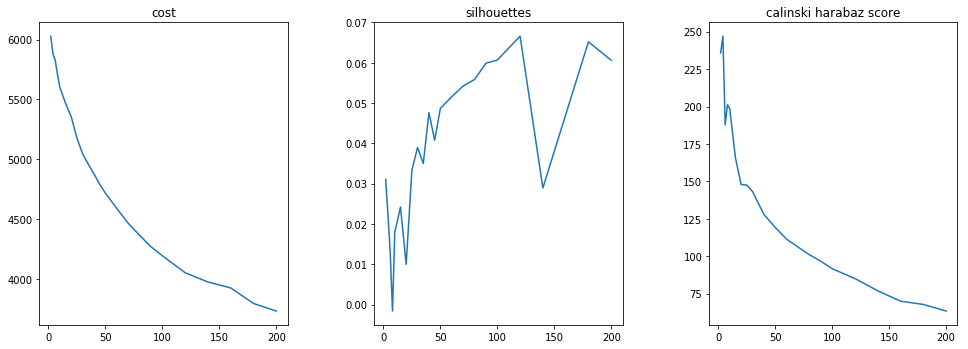

In [16]:
# Run again in transformed data
models, labels, costs, sil_avgs, ch_scores = runKmeansForMultipleCentroids(transformed_data)

In [17]:
# Chosen number of centroids for the agressive dimensionality reduction
chosen_i = 18 # Meaning 120 centroids.
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
# analyze_centroids(chosen_model, chosen_model_labels, transformed_data)

# Performance metrics using original data
sil_avg = silhouette_score(data, chosen_model_labels)
ch_score = calinski_harabaz_score(data, chosen_model_labels)

print('Silhouette avg:          %18.3f' % sil_avg)
print('Calinski-Harabasz Index: %18.3f' % ch_score)


Chosen # of centroids: 120
Cost:                              4050.248
Silhouette avg:                       0.067
Calinski-Harabasz Index:             85.074
Silhouette avg:                       0.021
Calinski-Harabasz Index:             21.112


In [18]:
red_sil_avgs, sil_avgs = [], []
num_components = [750, 500, 300, 150, 130, 120, 110, 100, 90, 80, 70, 50, 25]
for n in num_components:
    pca = PCA(n)
    transformed_data = pca.fit_transform(data)
    #model = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=1)
    model = chosen_model # TEMP 
    
    myLabels, cost, red_sil_avg, ch_score = computeKMeansMetrics(model, transformed_data)
    red_sil_avgs.append(red_sil_avg)
    sil_avg = silhouette_score(data, myLabels)
    sil_avgs.append(sil_avg)
    ch_scores.append(ch_score)

    print("%4d components: acc variance: %5.1f, red_sil_avg: %6.4f, sil_avg: %6.4f" % (
            n, round(sum(pca.explained_variance_ratio_) * 100), red_sil_avg, sil_avg))

 750 components: acc variance:  59.0, red_sil_avg: 0.0375, sil_avg: 0.0186
 500 components: acc variance:  46.0, red_sil_avg: 0.0412, sil_avg: 0.0160
 300 components: acc variance:  34.0, red_sil_avg: 0.0344, sil_avg: 0.0206
 150 components: acc variance:  23.0, red_sil_avg: 0.0872, sil_avg: 0.0223
 130 components: acc variance:  21.0, red_sil_avg: 0.0895, sil_avg: 0.0230
 120 components: acc variance:  21.0, red_sil_avg: 0.0853, sil_avg: 0.0188
 110 components: acc variance:  20.0, red_sil_avg: 0.0908, sil_avg: 0.0201
 100 components: acc variance:  19.0, red_sil_avg: 0.0872, sil_avg: 0.0187
  90 components: acc variance:  17.0, red_sil_avg: 0.0925, sil_avg: 0.0190
  80 components: acc variance:  16.0, red_sil_avg: 0.0914, sil_avg: 0.0159
  70 components: acc variance:  15.0, red_sil_avg: 0.0917, sil_avg: 0.0135
  50 components: acc variance:  12.0, red_sil_avg: 0.0856, sil_avg: 0.0096
  25 components: acc variance:   8.0, red_sil_avg: 0.0914, sil_avg: 0.0014


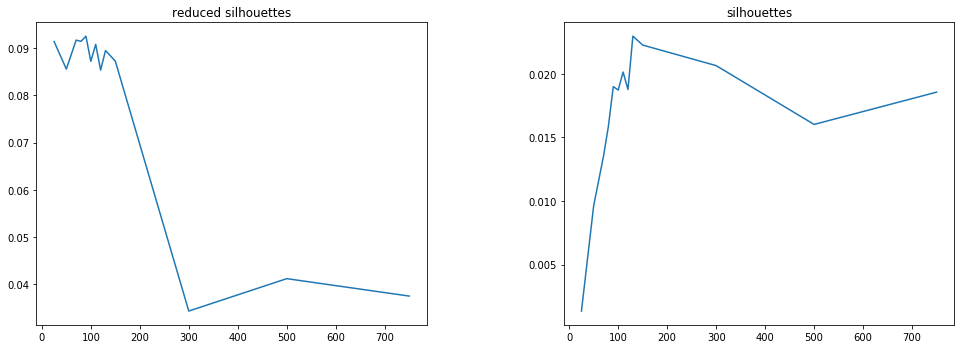

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='col')

ax1.set_title('reduced silhouettes')
ax1.plot(num_components, red_sil_avgs)

ax2.set_title('silhouettes')
ax2.plot(num_components, sil_avgs)

f.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
f.set_size_inches(15, 5)
f.show()